In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import linear_model
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')
import datetime


Модель ряда:

$$ 1.05\cos(\frac{2\pi}{24}n + \frac{3\pi}{4}) + 
                    0.82\cos(\frac{2\pi}{12} + \frac{\pi}{12}) + 
                    0.27\cos(\frac{2\pi}{8} - \frac{2\pi}{3}) + 
                    0.05\cos(\frac{2\pi}{6} - \frac{\pi}{3}) $$

In [2]:
def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = False, is_trend = False, change_type = 'mean'):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = (1.05*np.cos((2*np.pi*np.arange(0, ts_length))/24 + (3*np.pi)/4) + 
                    0.82*np.cos((2*np.pi*np.arange(0, ts_length))/12 + np.pi/12) + 
                    0.27*np.cos((2*np.pi*np.arange(0, ts_length))/8 - (2*np.pi/3)) + 
                    0.05*np.cos((2*np.pi*np.arange(0, ts_length))/6 - np.pi/3))    
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,0.05,ts_length)
    signal = signal_trend+signal_period+noise

#     change_point = np.random.choice(np.arange(points_to_skip,ts_length-points_to_skip),1)[0] # two-sides skip
    change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0] # one-side skip
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])


def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided
    
    
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)+1
#     print(norm)
#     print(time_series)
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)

    return(result)


def get_model_trend_X(time_series):
    ts_length = len(time_series)
#     X = np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
    X = np.hstack((
        np.array([1 for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
              ))
    return X

def get_model_sin_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]) #,
#         np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def get_model_sin_insight_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def estimate_parameters(X,Y,X_new=None,Y_new=None):
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    if X_new is not None:
        estimated_Y = clf.predict(X_new)
        Y = Y_new
    else:
        estimated_Y = clf.predict(X)
#         print(estimated_Y)
    return np.sum((Y - estimated_Y)**2)

def approximation_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_trend_X(time_series[0:window])
    left_right_X = get_model_trend_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def approximation_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_X(time_series[0:window])
    left_right_X = get_model_sin_X(time_series[0:int(window/2)])
#     right_X = get_model_sin_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm
    
    return(result)


def approximation_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_insight_X(time_series[0:window])
    left_right_X = get_model_sin_insight_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def prediction_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_trend_X(time_series[0:int(window/2)])
    right_X = get_model_trend_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_X(time_series[0:int(window/2)])
    right_X = get_model_sin_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def naive(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    
    norm = np.mean(time_series[half_window:window])/np.mean(time_series[0:half_window])-1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    result.extend([abs(x/left_right_ts_mean[i-half_window]-1) for i, x in enumerate(left_right_ts_mean) if i >= half_window])
    
    return(result/norm)

def cp_detection(cost_values, threshold):
    list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) if cost_value >= threshold]
    return(list_of_indexes)   

def any_to_list(inp):
    if isinstance(inp, list):
        return(inp)
    else:
        return([inp])

def cp_quality(actual, predicted, max_delay = 49):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    
    df.loc[(pd.isna(df['actual']) == True) & (pd.isna(df['predicted']) == False), 'predicted_binary'] = 1
    df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] < 0) & (df['delay'] > max_delay), 'predicted_binary'] = 0
    df['predicted_binary'] = df['predicted_binary'].fillna(1)
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 

def cp_detection_modeling(approach = 'approximation_mean', iterations = 1000, max_delay = 49, _window = 48, _cp_prob = 0.8, _is_multiplicative = True, threshold_list = [0.15], _is_trend = False, _change_type = 'mean', points_to_skip = None, mode=None):
    if not points_to_skip:
        points_to_skip = _window
    act, pred, tr = [], [], []
    for i in range(iterations):
        generated = data_generator(points_to_skip = points_to_skip, cp_prob = _cp_prob, is_multiplicative = _is_multiplicative, is_trend = _is_trend, change_type = _change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        for threshold in threshold_list:
            cp_2 = cp_detection(cp_1, threshold)

            act.append(generated[1])
            tr.append(threshold)
            if generated[1] == None:
                if len(cp_2) == 0:
                    pred.append(None)
                else:
                    if mode == 'change_end':
                        pred_list = [cp for cp in cp_2 
                                     if cp >= points_to_skip]
                        if len(pred_list) == 0:
                            pred.append(None)
                        else:
                            pred.append(pred_list[0])
                    else:
                        pred.append(cp_2[0])
            else:
                if len(cp_2) == 0:
                    pred.append(None)
                else:
                    if mode == 'change_end':
                        pred_list = [cp for cp in cp_2 
                                     if cp >= points_to_skip]
                        if len(pred_list) == 0:
                            pred.append(None)
                        else:
                            pred.append(pred_list[0])
                    else:
                        pred_list = [cp for cp in cp_2
                                        if ((cp - generated[1]) <= max_delay) &
                                           ((cp - generated[1]) >= 0)]
                        if len(pred_list) == 0:
                            pred.append(None)
                        else:
                            pred.append(pred_list[0])
        
    return([act, pred, tr])


def get_threshold_list(iterations = 1000, approach = 'approximation_mean', window = 48, cp_prob = 0.8, is_multiplicative = False, is_trend = False, change_type = 'mean', points_to_skip = None):
    if not points_to_skip:
        points_to_skip = window
    detection_values = []
    for i in range(iterations):  
        generated = data_generator(points_to_skip = points_to_skip, cp_prob = cp_prob, is_multiplicative = is_multiplicative, is_trend = is_trend, change_type = change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], window)
        else:
            raise ValueError("Unrecognized approach")
        detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
#     threshold_max = np.percentile(detection_values, 95)
    threshold_max = max(detection_values)*1.2
#     threshold_max = float(round(threshold_max,6))
    threshold_max = float(threshold_max)
    threshold_list = list(np.arange(0, threshold_max, threshold_max/1000))
    return(threshold_list)

In [155]:
def act_binary(ts, cp, delay):
    len_ts = len(ts)
    len_all_l = len_ts-delay+1
    all_l = [0]*len_all_l
    if cp:
        start_ind = max(cp-delay,-1)+1
        end_ind = min(cp,len_all_l-1)+1
        all_l[start_ind:end_ind] = [1]*(end_ind-start_ind)
        if len(all_l) != 393:
            print(len(all_l),start_ind, end_ind)
    return(all_l)

In [139]:
def merge_overlapping(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
#     sorted_by_lower_bound = intervals
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = [lower[0], upper_bound]  # replace by merged interval
            else:
                merged.append(higher)
    return merged

In [148]:
def pred_binary(ts, cp_pred, delay):
    len_ts = len(ts)
    len_all_l = len_ts-delay+1
    all_l = [0]*len_all_l
#     print(len(all_l))
    if cp_pred:
        intervals = []
        for cp in cp_pred:
            
            start_ind = max(cp-delay,-1) + 1 ### need to change 4 on points_to_skip
            end_ind = min(cp,len_all_l-1) + 1
            intervals.append((start_ind,end_ind))
        intervals = merge_overlapping(intervals)
        for interval in intervals:
#             print(interval, interval[1]-interval[0], len([1]*(interval[1]-interval[0])))
            all_l[interval[0]:interval[1]] = [1]*(interval[1]-interval[0])
    return(all_l)
    

In [3]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
# WINDOWS = [48, 4, 2]
WINDOWS = [2]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
# MAX_DELAYS = [49, 25, 13, 7, 4, 2]
MAX_DELAYS = [4]
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']


In [4]:
%%time
for i in range(100):
    generated_t = data_generator(points_to_skip = 2, 
                               cp_prob = 0.8, 
                               is_multiplicative = False, 
                               is_trend = False, 
                               change_type = 'mean'
                              )


    approximation_mean(generated_t[0],2)

CPU times: user 54.5 ms, sys: 2.46 ms, total: 57 ms
Wall time: 66.6 ms


### Сгенерируем один ряд и посмотрим на функции разладки разных методов

48


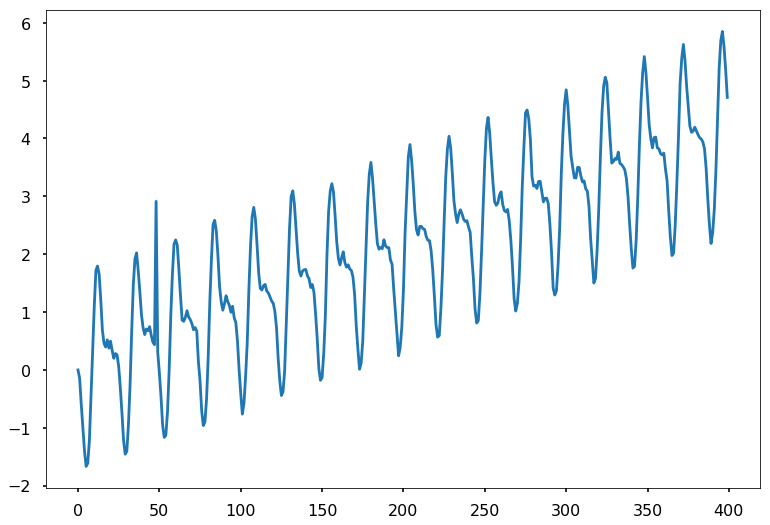

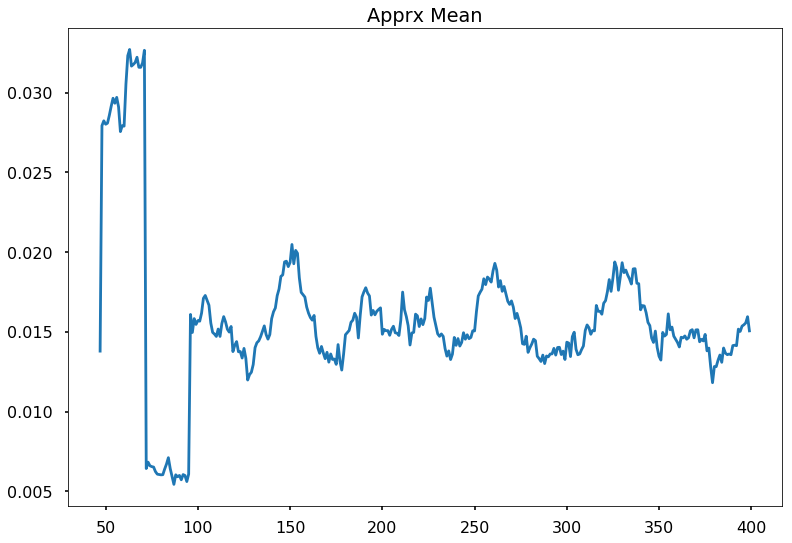

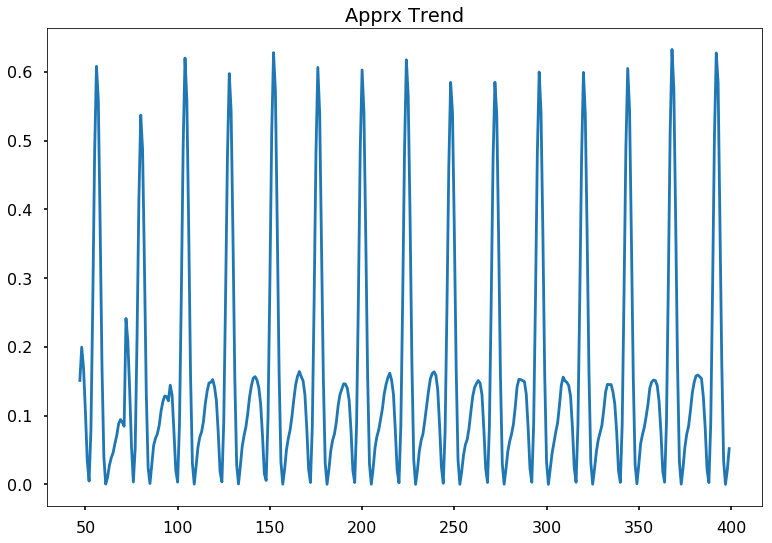

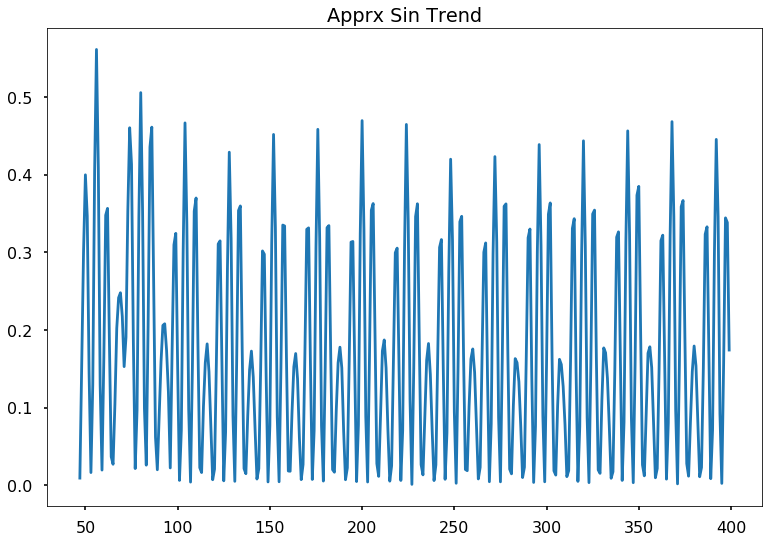

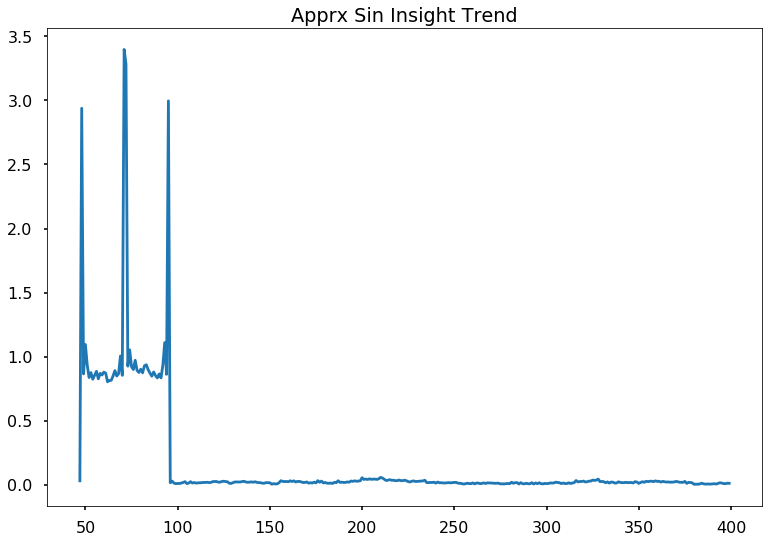

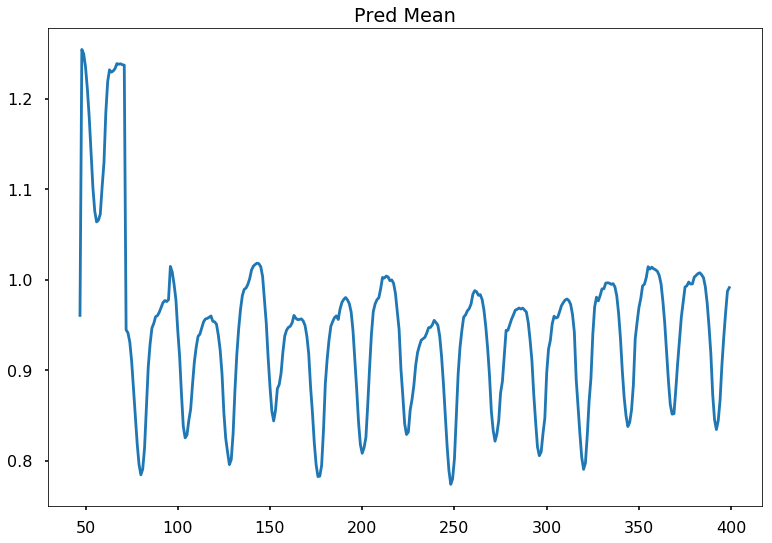

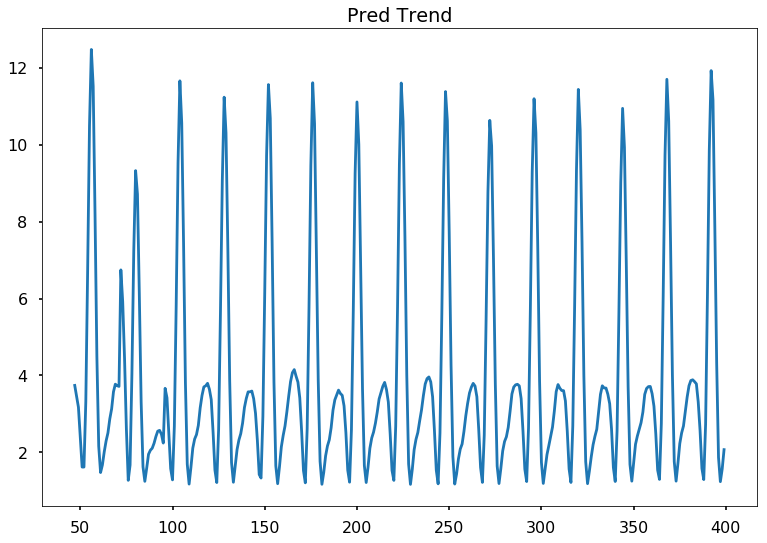

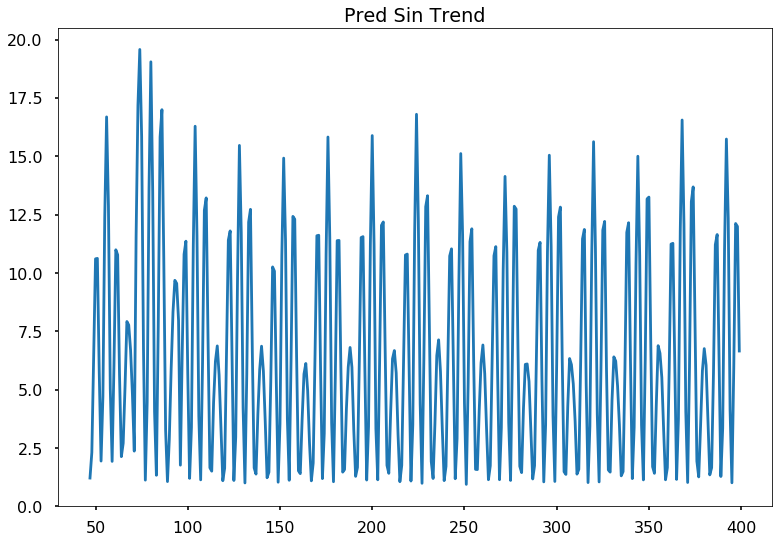

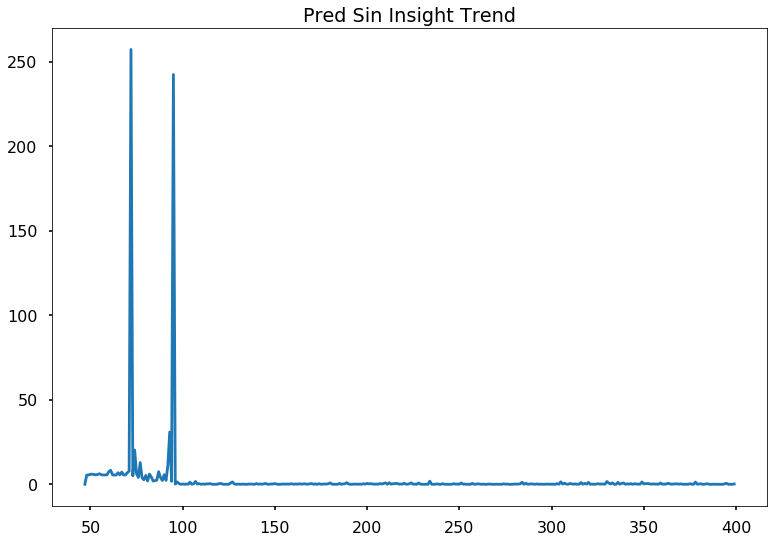

In [729]:

test_generated = data_generator(points_to_skip = 4, 
                           cp_prob = 0.8, 
                           is_multiplicative = False, 
                           is_trend = True, 
                           change_type = 'local')
test_cp_1 = approximation_mean(test_generated[0], window=48)
test_cp_2 = approximation_trend(test_generated[0], window=48)
test_cp_3 = approximation_sin_trend(test_generated[0], window=48)
test_cp_4 = approximation_sin_insight_trend(test_generated[0], window=48)
test_cp_5 = prediction_mean(test_generated[0], window=48)
test_cp_6 = prediction_trend(test_generated[0], window=48)
test_cp_7 = prediction_sin_trend(test_generated[0], window=48)
test_cp_8 = prediction_sin_insight_trend(test_generated[0], window=48)


prediction_sin_insight_trend

print(test_generated[1])
plt.plot(test_generated[0])
plt.show()
plt.plot(test_cp_1)
plt.title('Apprx Mean')
plt.show()
plt.plot(test_cp_2)
plt.title('Apprx Trend')
plt.show()
plt.plot(test_cp_3)
plt.title('Apprx Sin Trend')
plt.show()
plt.plot(test_cp_4)
plt.title('Apprx Sin Insight Trend')
plt.show()
plt.plot(test_cp_5)
plt.title('Pred Mean')
plt.show()
plt.plot(test_cp_6)
plt.title('Pred Trend')
plt.show()
plt.plot(test_cp_7)
plt.title('Pred Sin Trend')
plt.show()
plt.plot(test_cp_8)
plt.title('Pred Sin Insight Trend')
plt.show()

None


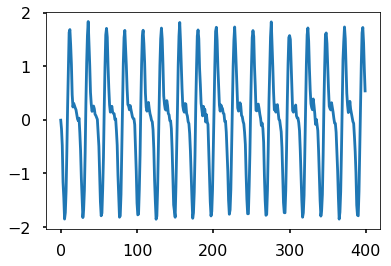

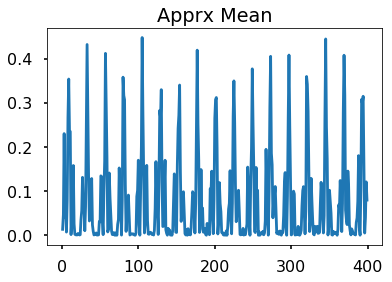

In [17]:

test_generated = data_generator(points_to_skip = 2, 
                           cp_prob = 0.8, 
                           is_multiplicative = False, 
                           is_trend = False, 
                           change_type = 'mean')
test_cp_1 = approximation_mean(test_generated[0], window=2)

prediction_sin_insight_trend

print(test_generated[1])
plt.plot(test_generated[0])
plt.show()
plt.plot(test_cp_1)
plt.title('Apprx Mean')
plt.show()

### Попробуем разные методы с разными параметрами

In [ ]:
'approximantion_trend',
'approximantion_sin_trend',
'approximantion_sin_insight_trend',
'prediction_trend',
'prediction_sin_trend',
'prediction_sin_insight_trend'

In [800]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
# WINDOWS = [48, 24, 4, 2]
WINDOWS = [48]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
# MAX_DELAYS = [49, 25, 13, 7, 4, 2]
MAX_DELAYS = [4]
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']



In [762]:
# APPROACHES = ['approximation_trend']

In [801]:
len(WINDOWS)*len(IS_TRENDS)*len(CHANGE_TYPES)*len(MAX_DELAYS)*len(APPROACHES)

54

In [754]:
# get_threshold_list(iterations = 100, 
#                    approach = 'approximation_trend', 
#                    window = 2, 
#                    cp_prob = 0.8, 
#                    is_multiplicative = False, 
#                    is_trend = False, 
#                    change_type = 'mean')
    
    

In [802]:
%%time

ITERATIONS = 20
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
# WINDOW = 48
# IS_TREND = False
# CHANGE_TYPE = 'mean'
# MAX_DELAY = 49
# APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


for WINDOW in WINDOWS:
    print('Start at {}'.format(datetime.datetime.now()))
#     print(WINDOW)
    for IS_TREND in IS_TRENDS:
        for CHANGE_TYPE in CHANGE_TYPES:
            for MAX_DELAY in MAX_DELAYS:
                for APPROACH in APPROACHES:
                    print('Approach {}'.format(APPROACH))
                    print('Loop at {}'.format(datetime.datetime.now()))
                    threshold_list = get_threshold_list(iterations = ITERATIONS,
                                                        approach = APPROACH,
                                                        window = WINDOW, 
                                                        cp_prob = CP_PROB, 
                                                        is_multiplicative = IS_MULTIPLICATIVE, 
                                                        is_trend = IS_TREND, 
                                                        change_type = CHANGE_TYPE
                                                       )

                    # threshold_list = [x/100 for x in range(100)]
                    # threshold_list = [x/1000 for x in range(1000)]
                    print('Got thresholds {}'.format(datetime.datetime.now()))
                    actual, predicted, thresholds = [], [], []
                    actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                                                  approach = APPROACH,
                                                                  max_delay = MAX_DELAY,
                                                                  _window = WINDOW,
                                                                  _cp_prob = CP_PROB,
                                                                  _is_multiplicative = IS_MULTIPLICATIVE,
                                                                  threshold_list = threshold_list,
                                                                  _is_trend = IS_TREND, 
                                                                  _change_type = CHANGE_TYPE
                                                                           )
                    print('Actual and precited calculated {}'.format(datetime.datetime.now()))
#                     for tr in threshold_list:
#                         print(tr)
#                         actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
#                                                                   approach = APPROACH,
#                                                                   max_delay = MAX_DELAY,
#                                                                   _window = WINDOW,
#                                                                   _cp_prob = CP_PROB,
#                                                                   _is_multiplicative = IS_MULTIPLICATIVE,
#                                                                   _threshold = tr,
#                                                                   _is_trend = IS_TREND, 
#                                                                   _change_type = CHANGE_TYPE
#                                                                            )
#                         actual.extend(actual_temp)
#                         predicted.extend(predicted_temp)
#                         thresholds.extend([tr]*len(actual_temp))

                    df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

                    precision = []
                    recall = []
                    specificity = []
                    average_delay = []
                    precision_filter = []
                    # test = []
                    for tr in threshold_list:
                        cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                                               df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                                               max_delay = MAX_DELAY
                                              )
                        if sum(cp_result[0][:,1]) == 0:
                            precision.append(1)
                        else:
                            precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

                        if sum(cp_result[0][1,:]) == 0:
                            recall.append(1)
                        else:
                            recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

                        if sum(cp_result[0][0,:]) == 0:
                            specificity.append(1)
                        else:
                            specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

                        if cp_result[1]:
                            average_delay.append(np.mean(cp_result[1]))
                            precision_filter.append(True)
                        else:
                            precision_filter.append(False)

                    #     test.append(cp_result[0])
                    print('Quality calculated {}'.format(datetime.datetime.now()))
                    unspecificity = [1-x for x in specificity]
                    
                    unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
                    df_results = df_results.append(pd.DataFrame(
                        {
                            'approach': APPROACH, 
                            'max_delay': MAX_DELAY, 
                            'change_type': CHANGE_TYPE,
                            'is_trend': IS_TREND,
                            'window': WINDOW, 
                            'cp_prob': CP_PROB, 
                            'is_multiplicative': IS_MULTIPLICATIVE, 
                            'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
                        }, index=[0]), ignore_index=True
                    )
                    print('End of loop {}'.format(datetime.datetime.now()))
#                     print('ROC AUC: {}'.format(np.trapz(unspecificity_sorted, recall_sorted)))

#                     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#                     plt.plot(unspecificity_sorted, recall_sorted)
#                     plt.ylabel('True positive rate')
#                     plt.xlabel('False positive rate')
#                     # plt.savefig('./fig/approximation_mean_2_roc.png')
#                     plt.show()

                    # plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
                    # plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
                    # plt.colorbar()
                    # plt.ylabel('True positive rate')
                    # plt.xlabel('False positive rate')
                    # plt.show()

Start at 2019-03-11 23:29:09.097817
Approach approximation_mean
Loop at 2019-03-11 23:29:09.097956
Got thresholds 2019-03-11 23:29:09.122159
Actual and precited calculated 2019-03-11 23:29:09.203843
Quality calculated 2019-03-11 23:29:10.644016
End of loop 2019-03-11 23:29:10.646426
Approach prediction_mean
Loop at 2019-03-11 23:29:10.646852
Got thresholds 2019-03-11 23:29:10.669224
Actual and precited calculated 2019-03-11 23:29:10.912848
Quality calculated 2019-03-11 23:29:12.382938
End of loop 2019-03-11 23:29:12.385551
Approach naive
Loop at 2019-03-11 23:29:12.385610
Got thresholds 2019-03-11 23:29:12.407325
Actual and precited calculated 2019-03-11 23:29:12.471885
Quality calculated 2019-03-11 23:29:13.712988
End of loop 2019-03-11 23:29:13.715466
Approach approximation_trend
Loop at 2019-03-11 23:29:13.715521
Got thresholds 2019-03-11 23:29:22.752302
Actual and precited calculated 2019-03-11 23:29:30.474612
Quality calculated 2019-03-11 23:29:31.952436
End of loop 2019-03-11 23:

Got thresholds 2019-03-11 23:34:27.189194
Actual and precited calculated 2019-03-11 23:34:29.971141
Quality calculated 2019-03-11 23:34:31.346478
End of loop 2019-03-11 23:34:31.351346
Approach prediction_sin_trend
Loop at 2019-03-11 23:34:31.351446
Got thresholds 2019-03-11 23:34:33.767900
Actual and precited calculated 2019-03-11 23:34:36.225711
Quality calculated 2019-03-11 23:34:37.455919
End of loop 2019-03-11 23:34:37.461533
Approach prediction_sin_insight_trend
Loop at 2019-03-11 23:34:37.461609
Got thresholds 2019-03-11 23:34:39.933520
Actual and precited calculated 2019-03-11 23:34:42.527612
Quality calculated 2019-03-11 23:34:43.752748
End of loop 2019-03-11 23:34:43.757824
Approach approximation_mean
Loop at 2019-03-11 23:34:43.757964
Got thresholds 2019-03-11 23:34:43.787345
Actual and precited calculated 2019-03-11 23:34:43.920630
Quality calculated 2019-03-11 23:34:45.176462
End of loop 2019-03-11 23:34:45.181343
Approach prediction_mean
Loop at 2019-03-11 23:34:45.181415

In [781]:
df_results

,ROC AUC,approach,change_type,cp_prob,is_multiplicative,is_trend,max_delay,window
0,0.134673,approximation_mean,mean,0.8,False,False,4,2
1,0.094635,prediction_mean,mean,0.8,False,False,4,2
2,0.325000,naive,mean,0.8,False,False,4,2
3,0.085714,approximation_trend,mean,0.8,False,False,4,2
4,0.101333,approximation_sin_trend,mean,0.8,False,False,4,2
5,0.167467,approximation_sin_insight_trend,mean,0.8,False,False,4,2
6,0.051282,prediction_trend,mean,0.8,False,False,4,2
7,0.082439,prediction_sin_trend,mean,0.8,False,False,4,2
8,0.070196,prediction_sin_insight_trend,mean,0.8,False,False,4,2
9,0.038271,approximation_mean,trend,0.8,False,False,4,2


In [803]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'max_delay',
                          'window'],
                         ['approach'])

cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

In [798]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'max_delay',
                          'window'],
                         ['approach'])

In [783]:
cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

In [54]:
# th_temp = threshold_list[5]
# print(th_temp)

# temp = cp_quality(df_cp.loc[df_cp['threshold'] == th_temp, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == th_temp, 'predicted'],
#                   max_delay = 4
#                           )[0]

# print(np.sum(temp))
# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

0.38291925
100
[[ 0 27]
 [ 7 66]]
Recall: 0.9041095890410958 
 FPR: 1.0


In [259]:
cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

### Построим одну ROC кривую

ROC AUC: 0.04772565561665913


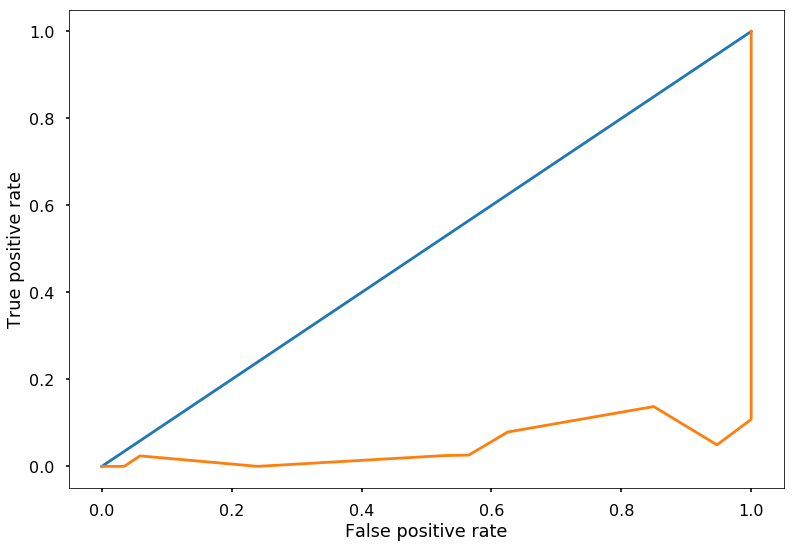

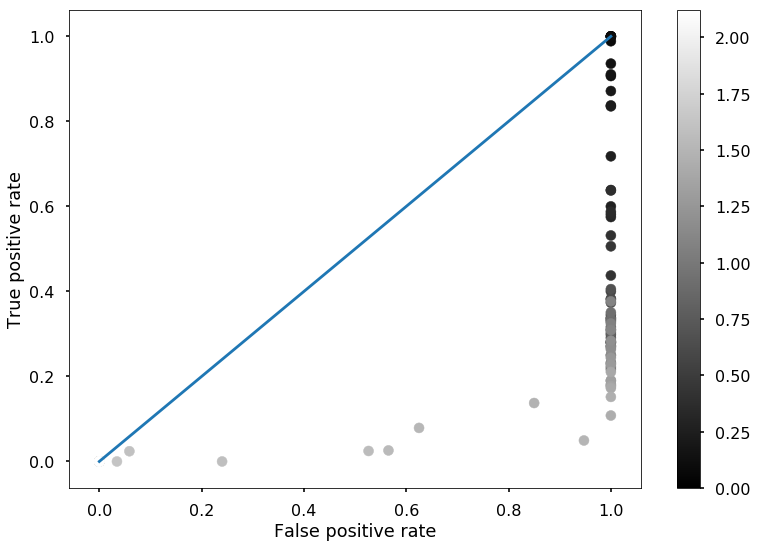

CPU times: user 7.49 s, sys: 68.6 ms, total: 7.56 s
Wall time: 7.62 s


In [178]:
%%time
# threshold_list = [x/100 for x in range(100)]
threshold_list = get_threshold_list(iterations = 100,
                                    window = 12,  
                                    is_multiplicative = False, 
                                    is_trend = True, 
                                    change_type = 'trend'
                                   )
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 100, 
                                              max_delay = 4,
                                              _window = 12,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr,
                                              _is_trend = True, 
                                              _change_type = 'trend'
                                                       )
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = 4
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_sorted, recall_sorted)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [210]:
# temp_tr = threshold_list[50]
# temp = cp_quality(df_cp.loc[df_cp['threshold'] == temp_tr, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == temp_tr, 'predicted'],
#                            max_delay = 4
#                           )[0]

# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

[[ 0 23]
 [52 25]]
Recall: 0.3246753246753247 
 FPR: 1.0


### Посмотрим на разброс значений ROC AUC для определенной конфигурации и 100 итерациях

In [34]:
roc_list_3 = []
for counter in range(50):
    # threshold_list = [x/100 for x in range(100)]
    threshold_list = get_threshold_list(iterations = 50,
                                        approach = 'approximation_mean',
                                        window = 2,  
                                        is_multiplicative = False, 
                                        is_trend = True, 
                                        change_type = 'mean'
                                       )
    # threshold_list = [x/1000 for x in range(1000)]
    actual, predicted, thresholds = [], [], []

    for tr in threshold_list:
        actual_temp, predicted_temp = cp_detection_modeling(iterations = 50, 
                                                  approach = 'approximation_mean',
                                                  max_delay = 4,
                                                  _window = 2,
                                                  _cp_prob = 0.8,
                                                  _is_multiplicative = False,
                                                  _threshold = tr,
                                                  _is_trend = True, 
                                                  _change_type = 'mean'
                                                           )
        actual.extend(actual_temp)
        predicted.extend(predicted_temp)
        thresholds.extend([tr]*len(actual_temp))

    df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

    precision = []
    recall = []
    specificity = []
    average_delay = []
    precision_filter = []
    # test = []

    for tr in threshold_list:
        cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                               df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                               max_delay = 4
                              )
        if sum(cp_result[0][:,1]) == 0:
            precision.append(1)
        else:
            precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

        if sum(cp_result[0][1,:]) == 0:
            recall.append(1)
        else:
            recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

        if sum(cp_result[0][0,:]) == 0:
            specificity.append(1)
        else:
            specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

        if cp_result[1]:
            average_delay.append(np.mean(cp_result[1]))
            precision_filter.append(True)
        else:
            precision_filter.append(False)

    #     test.append(cp_result[0])

    unspecificity = [1-x for x in specificity]


    unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
    
#     print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))
    
    roc_list_3.append(np.trapz(recall_sorted, unspecificity_sorted))

#     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#     plt.plot(unspecificity_sorted, recall_sorted)
#     plt.ylabel('True positive rate')
#     plt.xlabel('False positive rate')
#     # plt.savefig('./fig/approximation_mean_2_roc.png')
#     plt.show()

#     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#     plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
#     plt.colorbar()
#     plt.ylabel('True positive rate')
#     plt.xlabel('False positive rate')
#     plt.show()

Iterations: 100 Measures number: 50 Mean: 0.09 Standard deviation: 0.0095


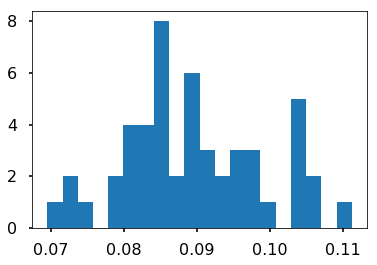

In [31]:
print('Iterations: 100 Measures number: {} Mean: {} Standard deviation: {}'.format(len(roc_list_2),
                                                                   round(np.mean(roc_list_2),2),
                                                                   round(np.sqrt(np.var(roc_list_2)),4)
                                                                  )
     )
plt.hist(roc_list_2, bins=20)
plt.show()

Iterations: 200 Measures number: 50 Mean: 0.09 Standard deviation: 0.0098


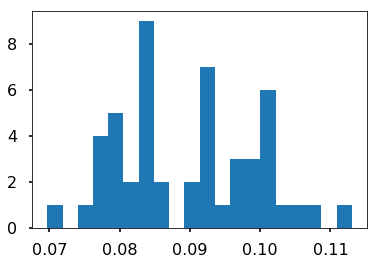

In [33]:
print('Iterations: 200 Measures number: {} Mean: {} Standard deviation: {}'.format(len(roc_list),
                                                                   round(np.mean(roc_list),2),
                                                                   round(np.sqrt(np.var(roc_list)),4)
                                                                  )
     )
plt.hist(roc_list, bins=20)
plt.show()

Iterations: 50 Measures number: 50 Mean: 0.09 Standard deviation: 0.0129


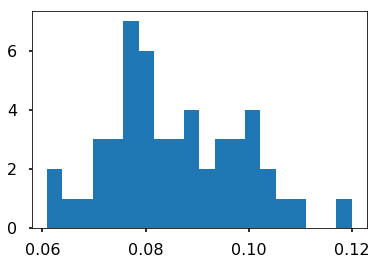

In [35]:
print('Iterations: 50 Measures number: {} Mean: {} Standard deviation: {}'.format(len(roc_list_3),
                                                                   round(np.mean(roc_list_3),2),
                                                                   round(np.sqrt(np.var(roc_list_3)),4)
                                                                  )
     )
plt.hist(roc_list_3, bins=20)
plt.show()

ROC AUC: 0.26211091647140516


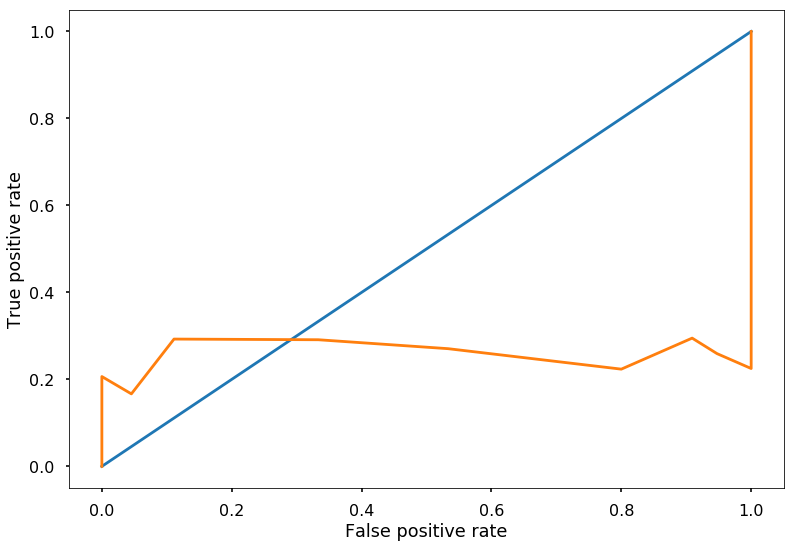

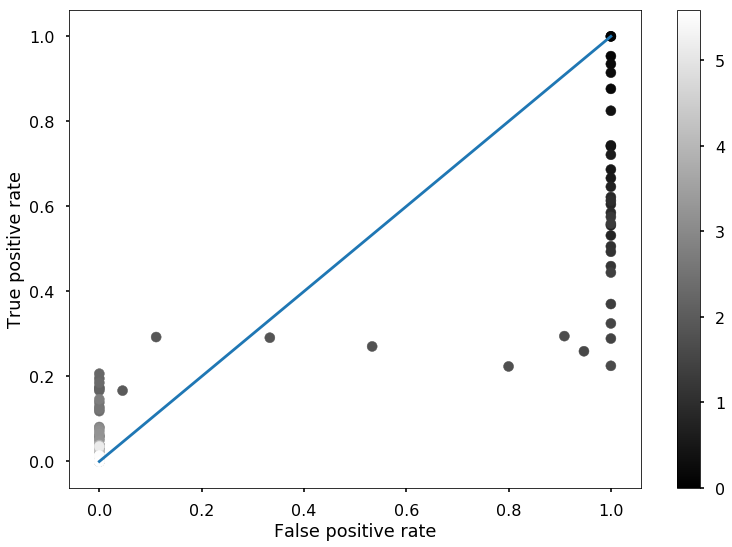

In [329]:
threshold_list = get_threshold_list(iterations = 100,
                                    approach = 'approximation_mean',
                                    window = 4,  
                                    is_multiplicative = False, 
                                    is_trend = False, 
                                    change_type = 'local',
                                    cp_prob=0.8
                                   )
# threshold_list = [x/1000 for x in range(1000)]
# search
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 100, 
                                              approach = 'approximation_mean',
                                              max_delay = 4,
                                              _window = 4,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr,
                                              _is_trend = False, 
                                              _change_type = 'local'
                                                       )
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = 4
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)

#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

#     roc_list_2.append(np.trapz(recall_sorted, unspecificity_sorted))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_sorted, recall_sorted)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [12]:
# th_temp = threshold_list[4]
# print(th_temp)

# temp = cp_quality(df_cp.loc[df_cp['threshold'] == th_temp, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == th_temp, 'predicted'],
#                   max_delay = 4
#                           )[0]

# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

0.31244932
[[ 0 18]
 [ 8 74]]
Recall: 0.9024390243902439 
 FPR: 1.0


In [158]:
def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = False, is_trend = False, change_type = 'mean'):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = np.arange(0, ts_length)   
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,1000,ts_length)
    signal = np.array([np.random.normal(0,0.05,1)]*ts_length).reshape(1,-1)[0] + noise

#     change_point = np.random.choice(np.arange(points_to_skip,ts_length-points_to_skip),1)[0] # two-sides skip
    change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0] # one-side skip
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]    
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])

In [127]:
def cp_detection_modeling(approach = 'approximation_mean', 
                            iterations = 1000, 
                            max_delay = 49, 
                            _window = 48, 
                            _cp_prob = 0.8, 
                            _is_multiplicative = True, 
                            threshold_list = [0.15], 
                            _is_trend = False, 
                            _change_type = 'mean', 
                            points_to_skip = None, 
                            mode=None):
    if not points_to_skip:
        points_to_skip = _window
    act, pred, tr = [], [], []
    gen_ts, cp_fun = [], []
    for i in range(iterations):
        generated = data_generator(points_to_skip = points_to_skip, cp_prob = _cp_prob, is_multiplicative = _is_multiplicative, is_trend = _is_trend, change_type = _change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        gen_ts.append(generated[0])
        cp_fun.append(cp_1)
        
        for threshold in threshold_list:
            cp_2 = cp_detection(cp_1, threshold)

            act.append(generated[1])
            tr.append(threshold)
            if generated[1] == None:
                if len(cp_2) == 0:
                    pred.append(None)
                else:
                    if mode == 'change_end':
                        pred_list = [cp for cp in cp_2 
                                     if cp >= points_to_skip]
                        if len(pred_list) == 0:
                            pred.append(None)
                        else:
                            pred.append(pred_list[0])
                    else:
                        pred.append(cp_2[0])
            else:
                if len(cp_2) == 0:
                    pred.append(None)
                else:
                    if mode == 'change_end':
                        pred_list = [cp for cp in cp_2 
                                     if cp >= points_to_skip]
                        if len(pred_list) == 0:
                            pred.append(None)
                        else:
                            pred.append(pred_list[0])
                    else:
                        pred_list = [cp for cp in cp_2
                                        if ((cp - generated[1]) <= max_delay) &
                                           ((cp - generated[1]) >= 0)]
                        if len(pred_list) == 0:
                            pred.append(None)
                        else:
                            pred.append(pred_list[0])
        
    return([act, pred, tr, gen_ts, cp_fun])



In [973]:
t_generated = data_generator(points_to_skip = 352, 
                                 cp_prob = 0.8, 
                                 is_multiplicative = False, 
                                 is_trend = False, 
                                 change_type = 'mean')
print(t_generated[1])
t_generated[1] == None

None


True

In [119]:
# reversed prediction here!!!!!
# def cp_quality(actual, predicted, max_delay = 49):
#     df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
#     df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
#     delay = list(df_temp['predicted'] - df_temp['actual'])
#     df.loc[(pd.isna(df['actual']) == False) & 
#            (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
#     df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
#     df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
#     df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 1
    
#     df.loc[(pd.isna(df['actual']) == True) & (pd.isna(df['predicted']) == False), 'predicted_binary'] = 0
#     df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] < 0) & (df['delay'] > max_delay), 'predicted_binary'] = 1
#     df['predicted_binary'] = df['predicted_binary'].fillna(0)
    
#     conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
#     return(conf_m, delay) 

In [128]:
# without delay!!!
def cp_quality(actual, predicted, max_delay = 49):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
#     df.loc[(pd.isna(df['actual']) == True) & (pd.isna(df['predicted']) == False), 'predicted_binary'] = 1
#     df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] < 0) & (df['delay'] > max_delay), 'predicted_binary'] = 0
#     df['predicted_binary'] = df['predicted_binary'].fillna(1)
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 



376
[0.38038932]


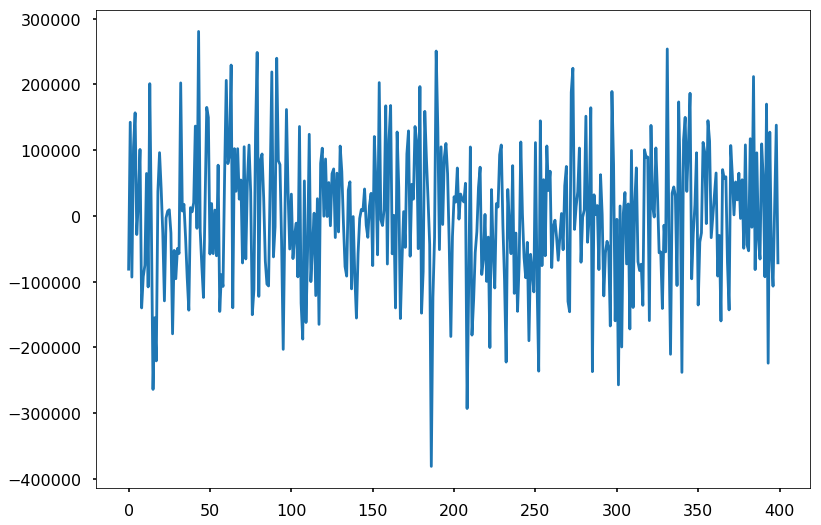

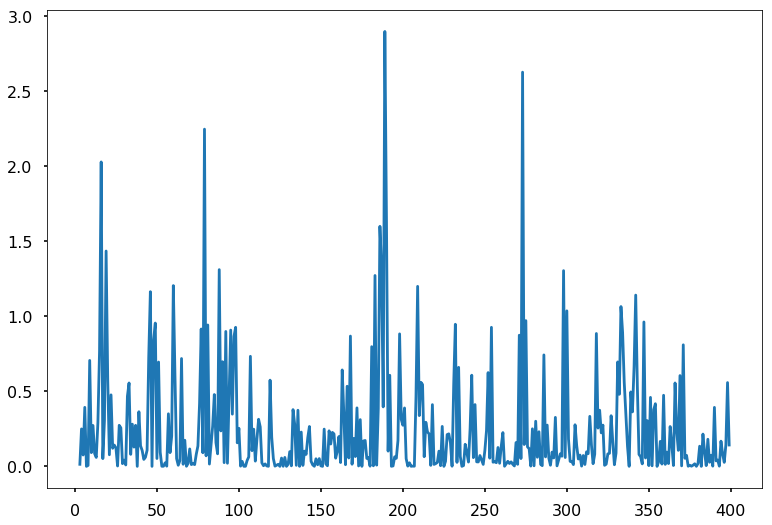

In [796]:
test = data_generator(cp_prob=0.8, points_to_skip = 352)
print(test[1])
print(test[2])
plt.plot(test[0])
plt.show()
plt.plot(approximation_mean(test[0], 4))
plt.show()

ROC AUC: 0.28184281842818426


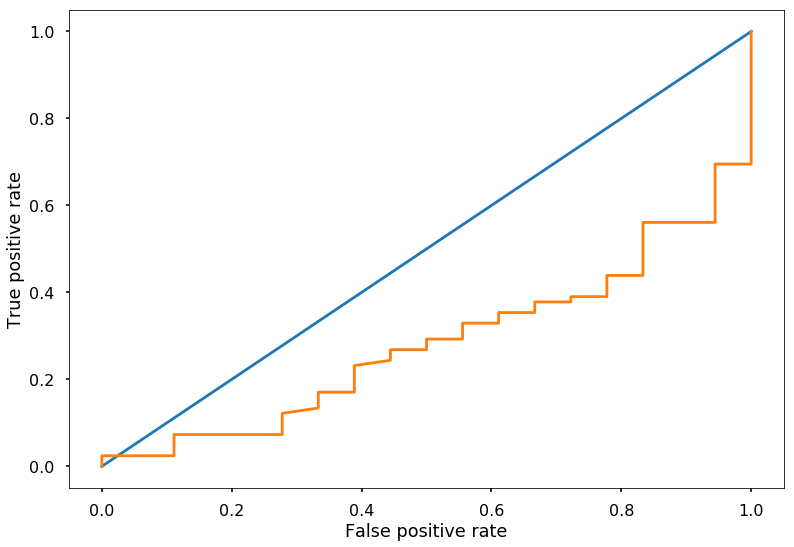

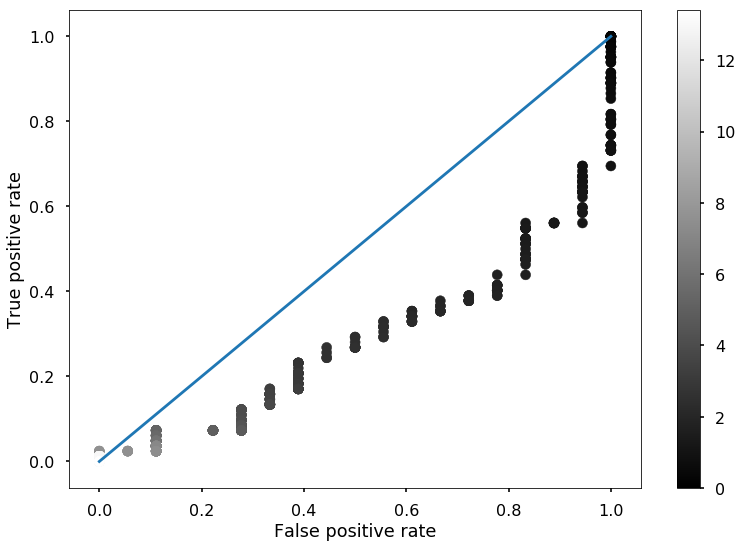

CPU times: user 23.1 s, sys: 78.4 ms, total: 23.2 s
Wall time: 23.3 s


In [426]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE
                                   )

# threshold_list = [x/100 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE
                                                       )
#                     for tr in threshold_list:
#                         print(tr)
#                         actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
#                                                                   approach = APPROACH,
#                                                                   max_delay = MAX_DELAY,
#                                                                   _window = WINDOW,
#                                                                   _cp_prob = CP_PROB,
#                                                                   _is_multiplicative = IS_MULTIPLICATIVE,
#                                                                   _threshold = tr,
#                                                                   _is_trend = IS_TREND, 
#                                                                   _change_type = CHANGE_TYPE
#                                                                            )
#                         actual.extend(actual_temp)
#                         predicted.extend(predicted_temp)
#                         thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = MAX_DELAY
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)

#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
df_results = df_results.append(pd.DataFrame(
    {
        'approach': APPROACH, 
        'max_delay': MAX_DELAY, 
        'change_type': CHANGE_TYPE,
        'is_trend': IS_TREND,
        'window': WINDOW, 
        'cp_prob': CP_PROB, 
        'is_multiplicative': IS_MULTIPLICATIVE, 
        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
    }, index=[0]), ignore_index=True
)
print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_sorted, recall_sorted)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [ ]:

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

In [239]:
act = [0,0,1,1,1,0,0,0,1,1,1,1,0,1]
pred = [0,1,1,0,0,0,1,1,0,0,0,1,0,0]
pred = [1,0,0,1,1,1,0,0,1,1,1,0,1,1]

In [ ]:
0.2
0.5

In [585]:
1 + \
1

2

In [790]:
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)+1
#     norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2) - \
#            np.sum((time_series[0:half_window] - np.mean(time_series[0:half_window]))**2) - \
#            np.sum((time_series[half_window:window] - np.mean(time_series[half_window:window]))**2) + 1
#     print(norm)
#     print(time_series)
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

In [721]:
t_m, t_v = np.empty(30000),np.empty(30000)

for i in range(30000):
    t_generated = data_generator(points_to_skip = 352, 
                             cp_prob = 0.8, 
                             is_multiplicative = False, 
                             is_trend = False, 
                             change_type = 'mean')
    t_cp_1 = approximation_mean(t_generated[0], 4)
    t_cp_1 = [x for x in t_cp_1 if np.isnan(x) == False]
    t_m[i] = np.mean(t_cp_1)
    t_v[i] = np.std(t_cp_1)
#     t_m.append(np.mean(t_cp_1))
#     t_v.append(np.std(t_cp_1))

print(np.std(t_m)/(np.mean(t_m)+1))
print(np.std(t_m))

0.0010058042171127426
0.0010160217158917929


In [ ]:
0.01 3sums: 0.00033 1sum: 0.00033 mean: 0.00033
0.1 3sums: 0.00101 1sum: 0.00100 mean: 0.00100
1 3sums: 0.1623794  1sum: 0.145248 mean: 0.115064
10 3sums: 1.76833  1sum: 1.12725  mean: 1.23772
100 3sums: 6.2899  1sum: 2.19653  mean: 3.71788
            
0.1 3sums: 0.001005527459826978 1sum: 0.0009989221640073736 mean: 0.0010005643179371408
0.1 3sums: 0.001014900968839493 1sum: 0.0010058042171127426 mean: 0.001008782990357749

In [316]:
np.sum((t_generated[0][0:32] - np.mean(t_generated[0][0:32]))**2)+1

2.8364177364934586

In [323]:
(t_generated[0][0:32] - np.mean(t_generated[0][0:32]))**2


array([2.79972813e+00, 5.91586443e-02, 1.55144320e-04, 3.81146900e-02,
       8.85930976e-01, 1.45693134e-01, 1.51841581e-01, 4.49530576e-02,
       4.99310216e+00, 1.98087289e-01, 5.88750388e-02, 2.28514673e-01,
       3.63823247e-01, 2.24855311e+00, 6.89437791e-02, 1.26870360e-01,
       3.54841801e-01, 3.59075949e-01, 1.61602392e+00, 5.60141467e+00,
       8.39286072e-03, 3.01721123e-01, 1.14765423e+00, 2.77855931e+00,
       2.98558968e-01, 5.57244475e-01, 4.58119751e+00, 2.03241636e-01,
       4.64467085e-01, 3.24071876e-02, 1.13935285e+00, 2.10978975e+00])

In [319]:
np.mean(t_generated[0][0:32])

-0.05294312498780429

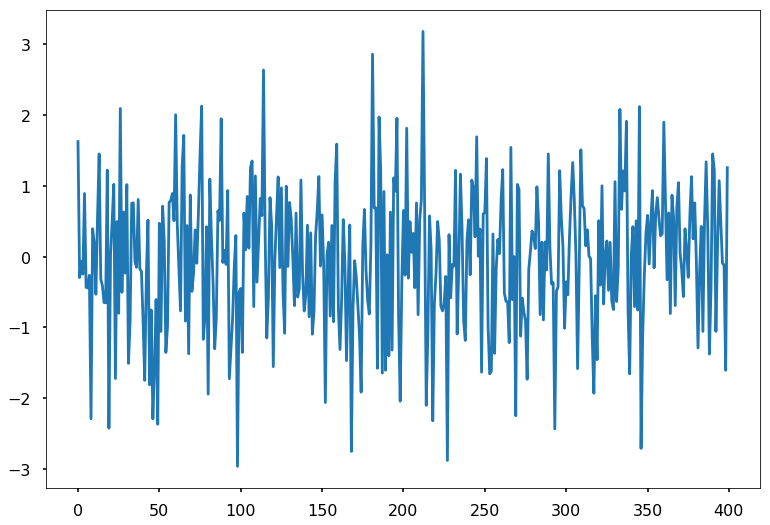

In [314]:
plt.plot(t_generated[0])

In [238]:
confusion_matrix(act,pred)

array([[3, 3],
       [6, 2]])

In [240]:
confusion_matrix(act,pred)

array([[3, 3],
       [2, 6]])

In [611]:
tt_norm = []
tt_ts_cost = []
for i in range(1000):
    t_generated = data_generator(points_to_skip = 352, 
                                 cp_prob = 0.8, 
                                 is_multiplicative = False, 
                                 is_trend = False, 
                                 change_type = 'mean')
    t_cp_1, t_norm, t_ts_cost = approximation_mean(t_generated[0], 4)
    tt_norm.append(t_norm)
    tt_ts_cost.append(t_ts_cost)

ValueError: not enough values to unpack (expected 3, got 2)

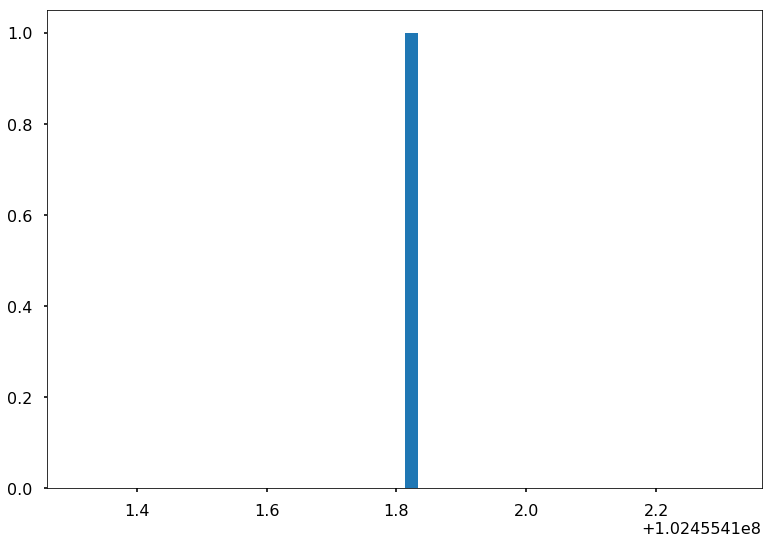

102455411.81248295 0.0


In [597]:
plt.hist(t_ts_cost,bins=50)
plt.show()
print(np.mean(t_ts_cost), np.std(t_ts_cost))


In [626]:
tt_norm = []
for i in range(1000):
    t_generated = data_generator(points_to_skip = 352, 
                                 cp_prob = 0.8, 
                                 is_multiplicative = False, 
                                 is_trend = False, 
                                 change_type = 'mean')
    t_cp_1, t_norm = approximation_mean(t_generated[0], 4)
    tt_norm.append(t_norm)

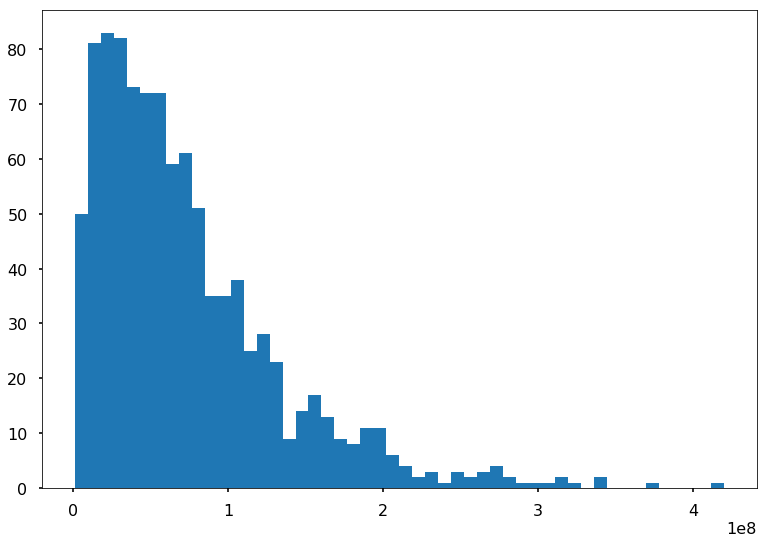

74030754.02710846 60934320.31417294


In [627]:
plt.hist(tt_norm,bins=50)
plt.show()
print(np.mean(tt_norm), np.std(tt_norm))


In [624]:
min(tt_norm)

958774.0059134811

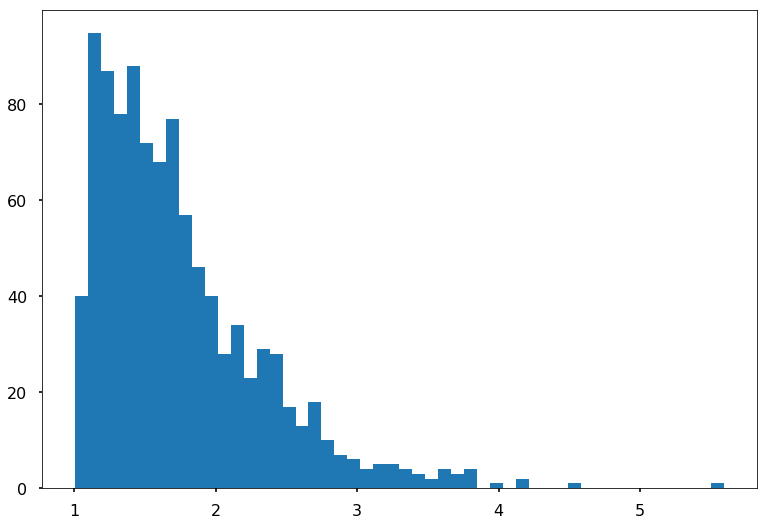

1.7480269059600135 0.5887368526130268


In [340]:
plt.hist(tt_norm,bins=50)
plt.show()
print(np.mean(tt_norm), np.std(tt_norm))


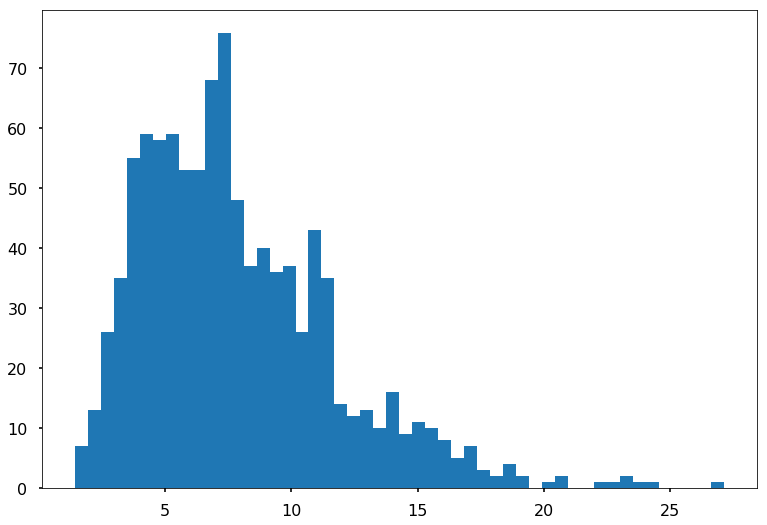

7.895858886258878 3.855247041274868


In [305]:
plt.hist(tt_norm,bins=50)
plt.show()
print(np.mean(tt_norm), np.std(tt_norm))


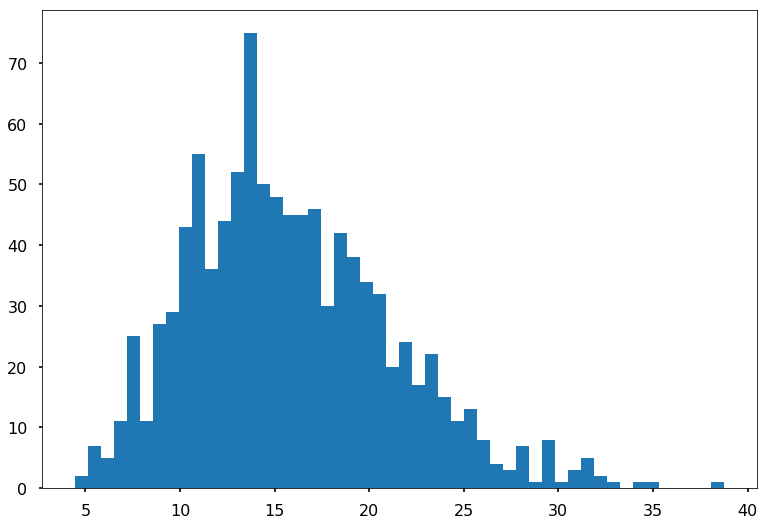

15.871759646818271 5.418133943265763


In [308]:
plt.hist(tt_norm,bins=50)
plt.show()
print(np.mean(tt_norm), np.std(tt_norm))


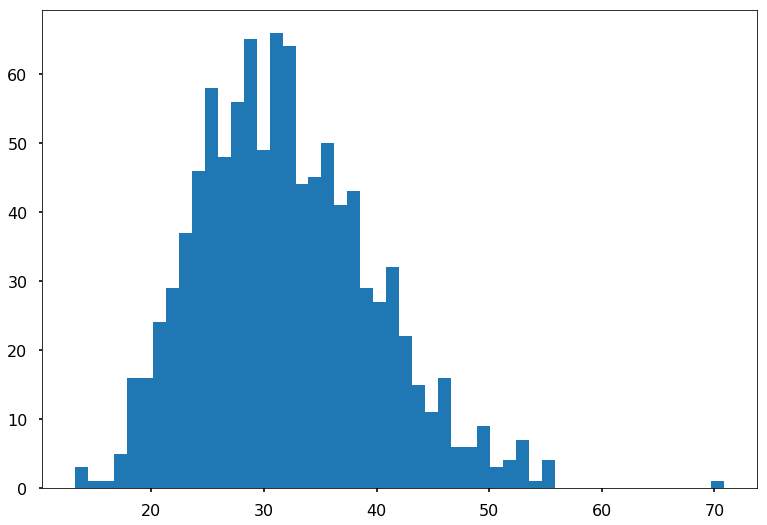

32.0233355683089 7.796226387715298


In [313]:
plt.hist(tt_norm,bins=50)
plt.show()
print(np.mean(tt_norm), np.std(tt_norm))


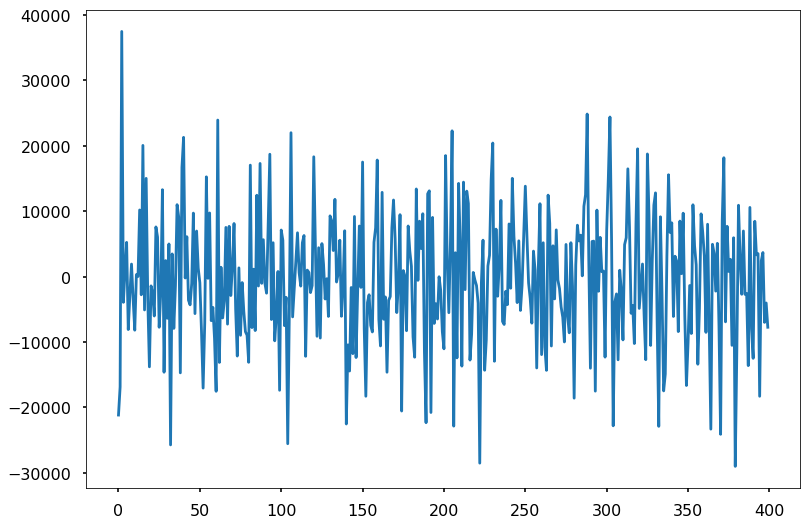

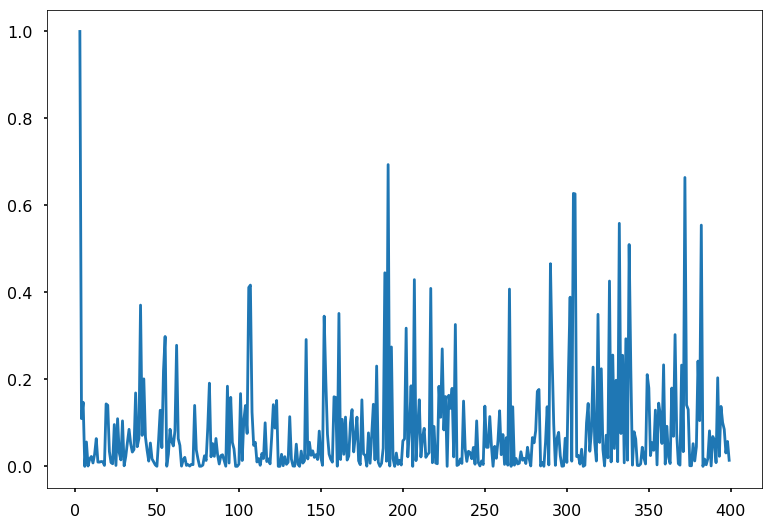

In [591]:
plt.plot(t_generated[0])
plt.show()
plt.plot(t_cp_1)
plt.show()


In [392]:
act = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0]
pred = [0,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0]
confusion_matrix(act,pred)

array([[ 1,  0],
       [11,  8]])

In [399]:
t_generated = data_generator(points_to_skip = 352, 
                             cp_prob = 0.8, 
                             is_multiplicative = False, 
                             is_trend = False, 
                             change_type = 'mean')
t_cp_1 = approximation_mean(t_generated[0], 4)
t_cp_2 = cp_detection(t_cp_1, 0.89)


# plt.plot(t_generated[0])
# plt.show()
# plt.plot(t_cp_1)
# plt.show()

print(np.mean([x for x in t_cp_1 if np.isnan(x) == False]))
print(t_generated[1])
print(t_cp_2)

0.7849442539691189
376
[5, 8, 20, 21, 35, 37, 39, 44, 45, 48, 50, 51, 54, 55, 56, 58, 66, 70, 72, 73, 79, 80, 82, 100, 102, 104, 107, 108, 114, 115, 117, 119, 123, 128, 135, 145, 146, 148, 151, 154, 157, 169, 172, 175, 177, 180, 182, 195, 196, 197, 205, 213, 217, 222, 223, 228, 230, 231, 233, 234, 240, 244, 245, 250, 252, 253, 254, 255, 261, 263, 264, 265, 267, 269, 275, 281, 285, 289, 290, 300, 307, 309, 317, 319, 320, 321, 322, 323, 326, 327, 329, 339, 342, 343, 345, 347, 356, 358, 359, 361, 363, 365, 366, 368, 382, 387, 388, 389, 390, 392, 393, 395, 396]


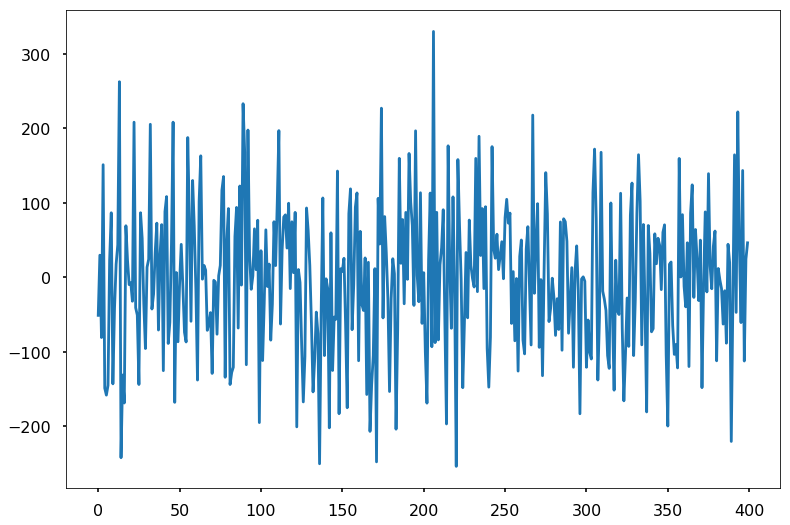

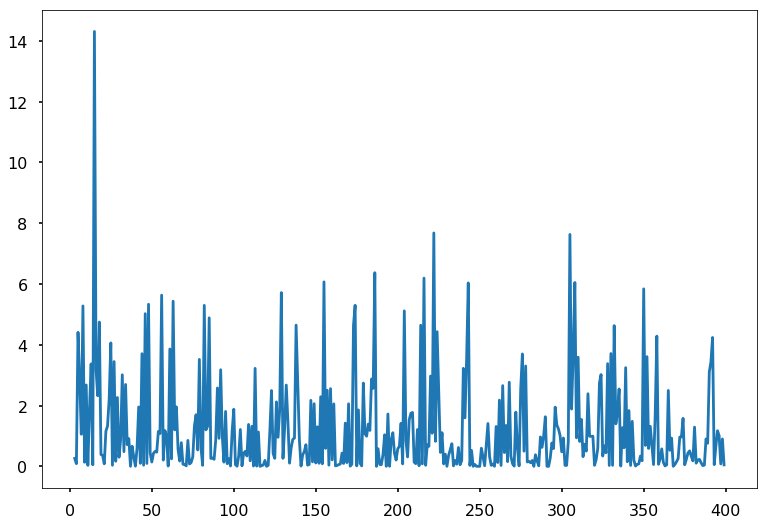

8074.700819280404

In [478]:
plt.plot(t_generated[0])
plt.show()
plt.plot(t_cp_1)
plt.show()

np.mean((t_generated[0][0:4] - np.mean(t_generated[0][0:4]))**2)+1

In [476]:
np.mean((t_generated[0][0:4] - np.mean(t_generated[0][0:4]))**2)+1


783.5014484913455

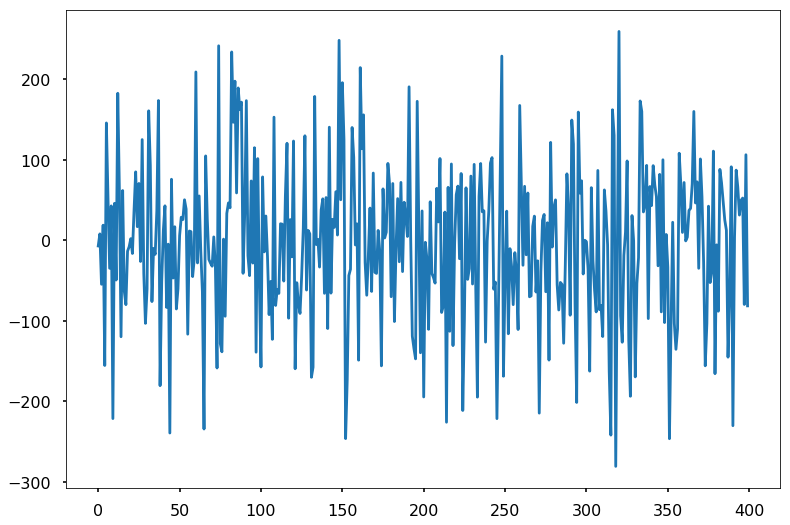

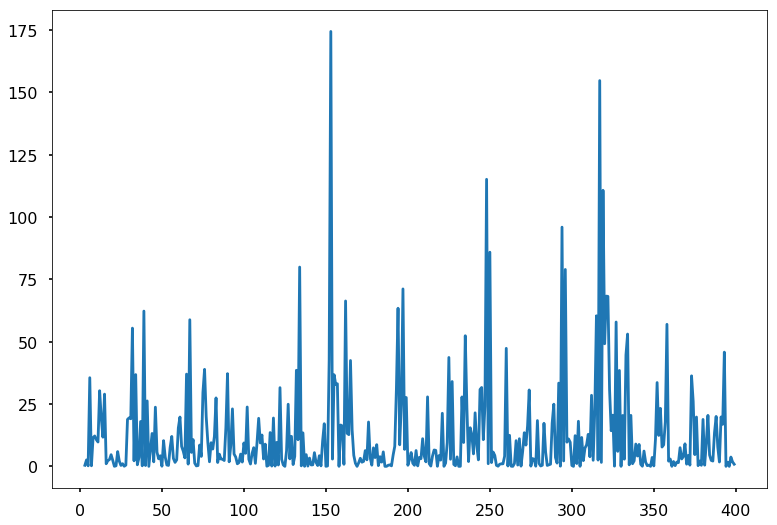

In [475]:
plt.plot(t_generated[0])
plt.show()
plt.plot(t_cp_1)
plt.show()


In [ ]:
act = [1,1,1,1,0]
pred = [0,0,0,1,0]
confusion_matrix(act,pred)

In [477]:
t_generated = data_generator(points_to_skip = 352, 
                             cp_prob = 0.8, 
                             is_multiplicative = False, 
                             is_trend = False, 
                             change_type = 'mean')
t_cp_1 = approximation_mean(t_generated[0], 4)
t_cp_2 = cp_detection(t_cp_1, 18)


# plt.plot(t_generated[0])
# plt.show()
# plt.plot(t_cp_1)
# plt.show()

print(np.mean([x for x in t_cp_1 if np.isnan(x) == False]))
print(t_generated[1])
print(t_cp_2)

1.2224514839532732
None
[]


In [783]:
act = [1,0,0,0,1,0,1]
pred = [1,1,1,0,0,0,1]
confusion_matrix(act,pred)

array([[2, 2],
       [1, 2]])

In [781]:
t_generated = data_generator(points_to_skip = 352, 
                             cp_prob = 0.8, 
                             is_multiplicative = False, 
                             is_trend = False, 
                             change_type = 'mean')
t_cp_1 = approximation_mean(t_generated[0], 4)
t_cp_2 = cp_detection(t_cp_1, 0.1)


# plt.plot(t_generated[0])
# plt.show()
# plt.plot(t_cp_1)
# plt.show()

print(np.mean([x for x in t_cp_1 if np.isnan(x) == False]))
print(t_generated[1])
print(t_cp_2)

0.009317627907823593
373
[374]


In [807]:
act = [1,0,0,1,1,1,1,1,0]
pred = [1,1,1,1,1,1,1,1,1]
confusion_matrix(act,pred)

array([[0, 2],
       [0, 4]])

In [842]:
len(t_act)

1000

In [846]:
t_generated[1]

358

In [849]:
t_act[6]

In [858]:
(t_act[6] is None)*1

0

In [852]:
(t_act[6] > 0)*1

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [932]:
t_act, t_pred = [],[]
for i in range(1000):
    check = 0
    t_generated = data_generator(points_to_skip = 352, 
                                 cp_prob = 0.8, 
                                 is_multiplicative = False, 
                                 is_trend = False, 
                                 change_type = 'mean')
    t_cp_1 = approximation_mean(t_generated[0], 4)
    t_cp_2 = cp_detection(t_cp_1, 0.69)
    t_act.append((t_generated[1] is None)*1)
    for j in t_cp_2:
        if j >= 352:
            t_pred.append(1)
            check = 1
            break
    if check == 0:
        t_pred.append(0)

t_conf_m = confusion_matrix(t_act,t_pred)
t_conf_stats = t_conf_m[:,1]/np.sum(t_conf_m,axis=1)
print(t_conf_m)
print('Recall: {} FPR: {}'.format(t_conf_stats[0], t_conf_stats[1]))

# plt.plot(t_generated[0])
# plt.show()
# plt.plot(t_cp_1)
# plt.show()

# print(np.mean([x for x in t_cp_1 if np.isnan(x) == False]))
# print(t_generated[1])
# print(t_cp_2)

[[ 54 764]
 [  7 175]]
Recall: 0.9339853300733496 FPR: 0.9615384615384616


(0.9828220858895705, 0.9837837837837838)

IndexError: tuple index out of range

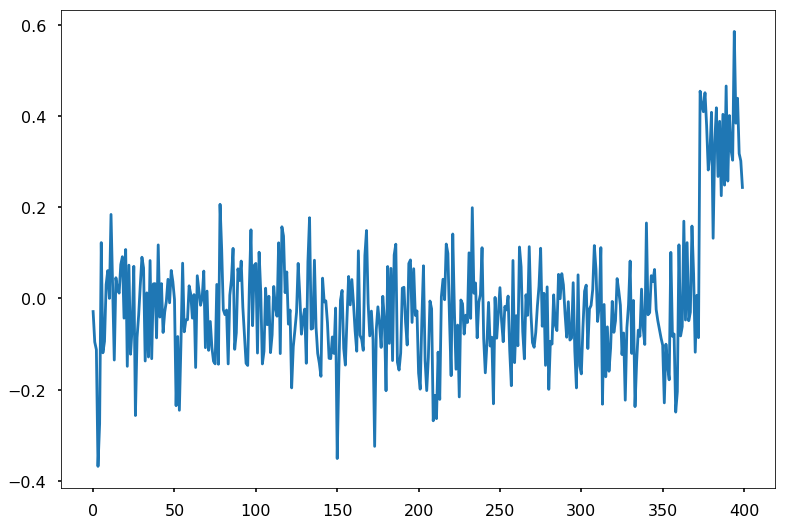

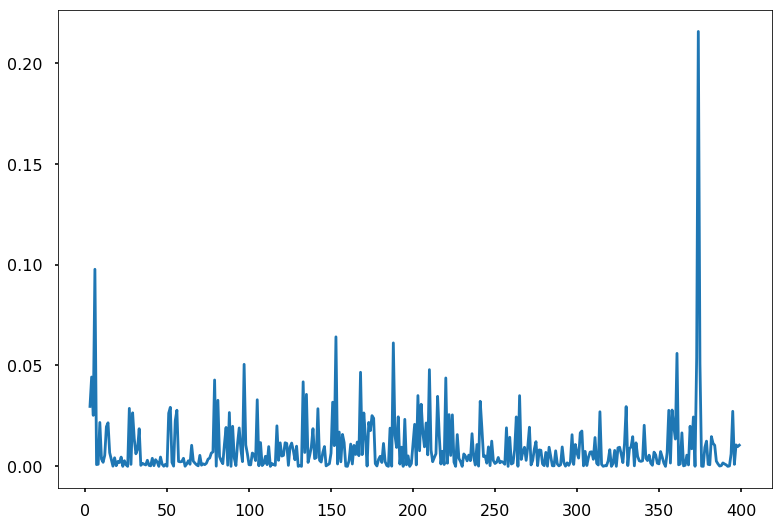

In [782]:
plt.plot(t_generated[0])
plt.show()
plt.plot(t_cp_1)
plt.show()


array([ 5795.70205318, 20384.8061627 ,   129.78510362,  2755.64687404,
       23011.22765018, 12031.1716894 ,  3802.37190264, 12101.56331903,
       25814.43568619,  2779.53887521])

In [606]:
t_generated = data_generator(points_to_skip = 352, 
                             cp_prob = 0.8, 
                             is_multiplicative = False, 
                             is_trend = False, 
                             change_type = 'mean')
t_cp_1 = approximation_mean(t_generated[0], 4)
t_cp_1 = [x for x in t_cp_1 if np.isnan(x) == False]

In [599]:
t_m, t_v = np.empty(10000),np.empty(10000)

for i in range(10000):
    t_generated = data_generator(points_to_skip = 352, 
                             cp_prob = 0.8, 
                             is_multiplicative = False, 
                             is_trend = False, 
                             change_type = 'mean')
    t_cp_1 = approximation_mean(t_generated[0], 4)
    t_cp_1 = [x for x in t_cp_1 if np.isnan(x) == False]
    t_m[i] = np.mean(t_cp_1)
    t_v[i] = np.std(t_cp_1)
#     t_m.append(np.mean(t_cp_1))
#     t_v.append(np.std(t_cp_1))

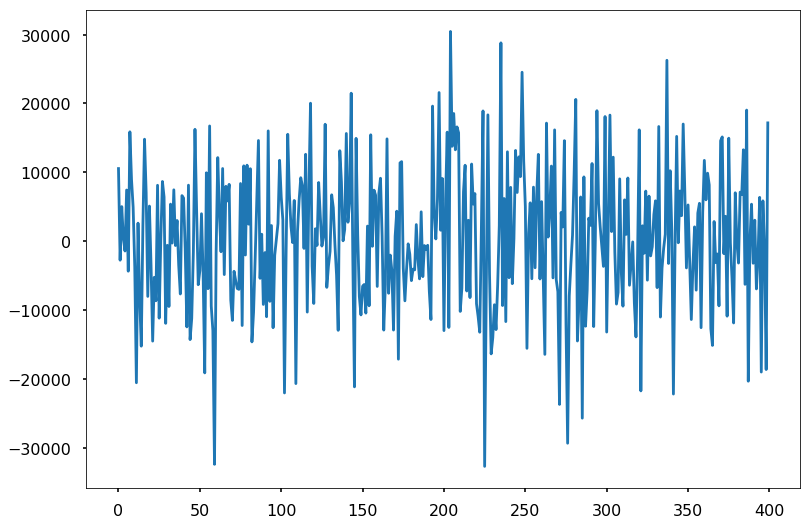

In [608]:
plt.plot(t_generated[0])
plt.show()

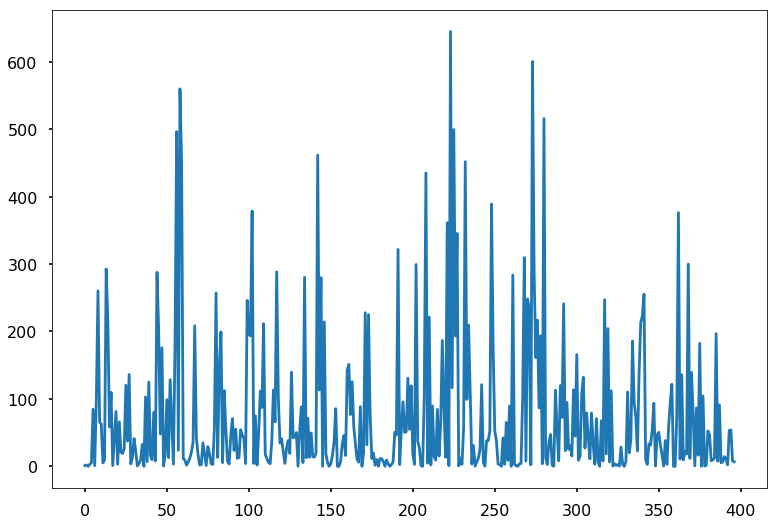

In [607]:
plt.plot(t_cp_1)
plt.show()

In [570]:
np.mean(t_m)

-0.0025327880395544502

In [600]:
print(np.std(t_m)/(np.mean(t_m)+1))
print(np.std(t_m))

61.739079681822375
610252.0381213202


In [543]:
np.std(t_m)/(np.mean(t_m)+1)

2.3031366684384063

In [544]:
np.std(t_m)

10.91503466699257

In [535]:
np.std(t_m)/(np.mean(t_m)+1)

1.4995496206249574

In [538]:
np.std(t_m)

2.913778627922739

In [515]:
np.std(t_m)

2.7646248562681843

In [513]:
np.mean(t_m)

0.958053548207648

In [497]:
np.std(t_m)/np.mean(t_m)

1.847911534062371

In [372]:
np.mean(t_m)

0.3521500076855616

In [369]:
np.std(t_m)

0.20139347787535908

In [401]:
np.std(t_m)/np.mean(t_m)

0.28781307131020184

In [368]:
np.std(t_m)/np.mean(t_m)

0.5719621300126242

In [360]:
np.std(t_m)/np.mean(t_m)

-0.3199799575340839

In [ ]:
np.std(t_m)/np.mean(t_m)

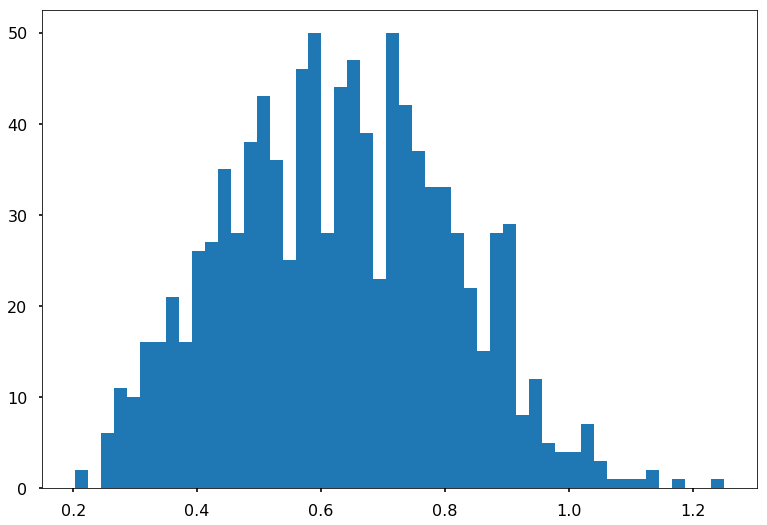

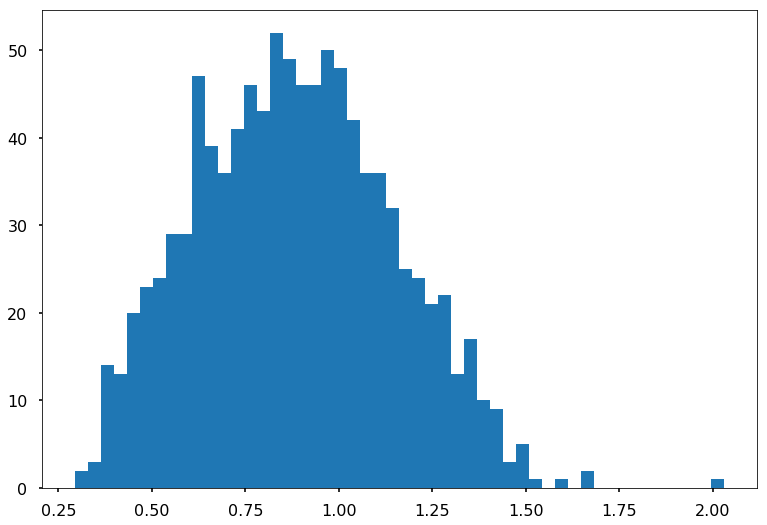

In [402]:
plt.hist(t_m, bins=50)
plt.show()
plt.hist(t_v, bins=50)
plt.show()

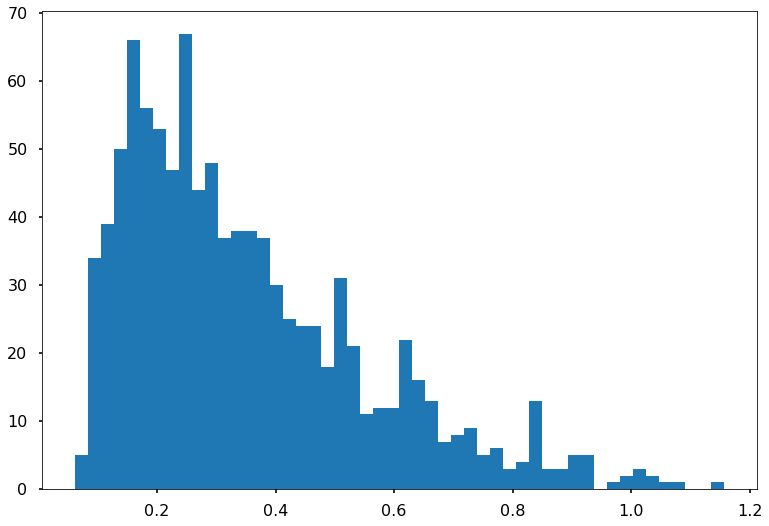

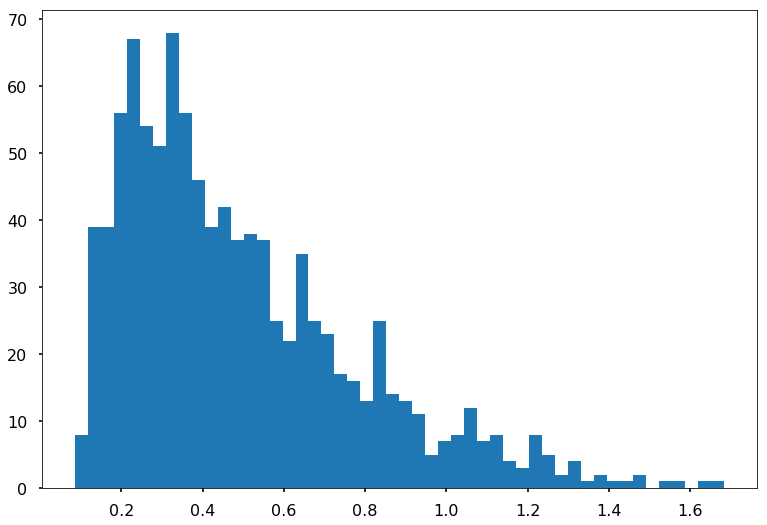

In [373]:
plt.hist(t_m, bins=50)
plt.show()
plt.hist(t_v, bins=50)
plt.show()

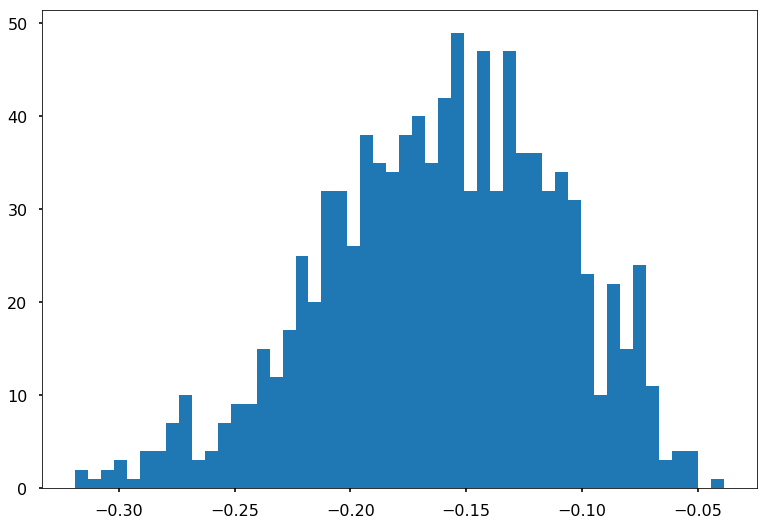

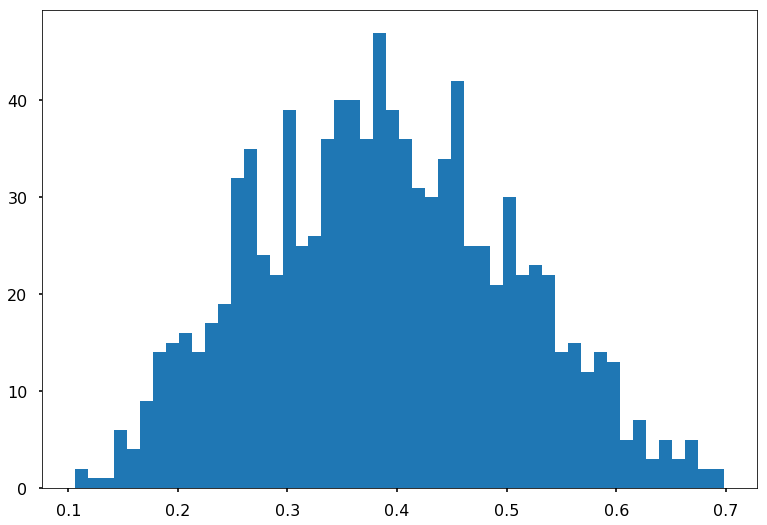

In [358]:
plt.hist(t_m, bins=50)
plt.show()
plt.hist(t_v, bins=50)
plt.show()

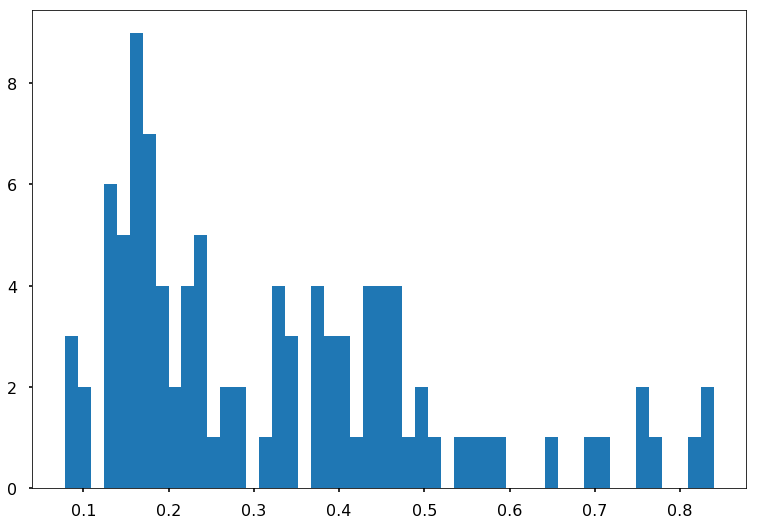

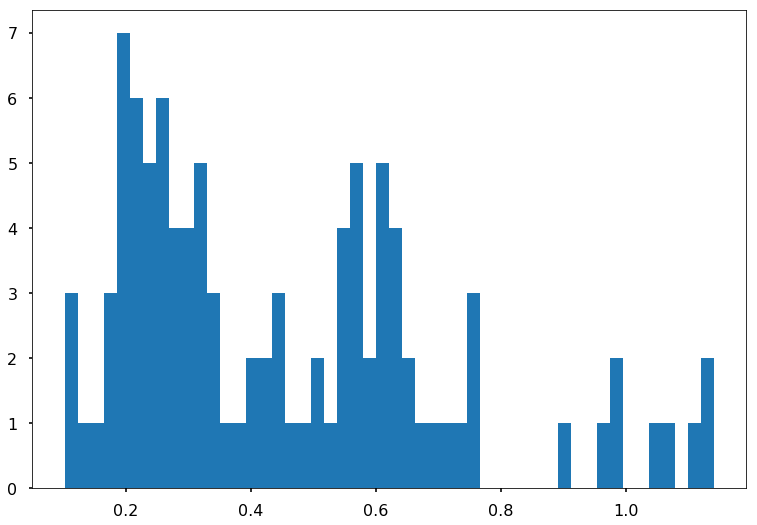

In [226]:
plt.hist(t_m, bins=50)
plt.show()
plt.hist(t_v, bins=50)
plt.show()

[]

In [ ]:
for i in range(iterations):
    generated = data_generator(points_to_skip = points_to_skip, cp_prob = _cp_prob, is_multiplicative = _is_multiplicative, is_trend = _is_trend, change_type = _change_type)
    cp_1 = approximation_mean(generated[0], _window)
    cp_2 = cp_detection(cp_1, threshold)

    gen_ts.append(generated[0])
    cp_fun.append(cp_1)

    for threshold in threshold_list:
        
    if generated[1] == None:
        if len(cp_2) == 0:
            pred.append(None)
        else:
            if mode == 'change_end':
                pred_list = [cp for cp in cp_2 
                             if cp >= points_to_skip]
                if len(pred_list) == 0:
                    pred.append(None)
                else:
                    pred.append(pred_list[0])
            else:
                pred.append(cp_2[0])
    else:
        if len(cp_2) == 0:
            pred.append(None)
        else:
            pred_list = [cp for cp in cp_2
                            if ((cp - generated[1]) <= max_delay) &
                               ((cp - generated[1]) >= 0)]
            if len(pred_list) == 0:
                pred.append(None)
            else:
                pred.append(pred_list[0])

return([act, pred, tr, gen_ts, cp_fun])

In [ ]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


# threshold_list = [x/100 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []
actual, predicted, thresholds, generated_ts, change_function = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              points_to_skip = 352,
                                              mode = 'change_end'
                                                       )

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = MAX_DELAY
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
    print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
df_results = df_results.append(pd.DataFrame(
    {
        'approach': APPROACH, 
        'max_delay': MAX_DELAY, 
        'change_type': CHANGE_TYPE,
        'is_trend': IS_TREND,
        'window': WINDOW, 
        'cp_prob': CP_PROB, 
        'is_multiplicative': IS_MULTIPLICATIVE, 
        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
    }, index=[0]), ignore_index=True
)
print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

ROC AUC: 0.5014405905547585


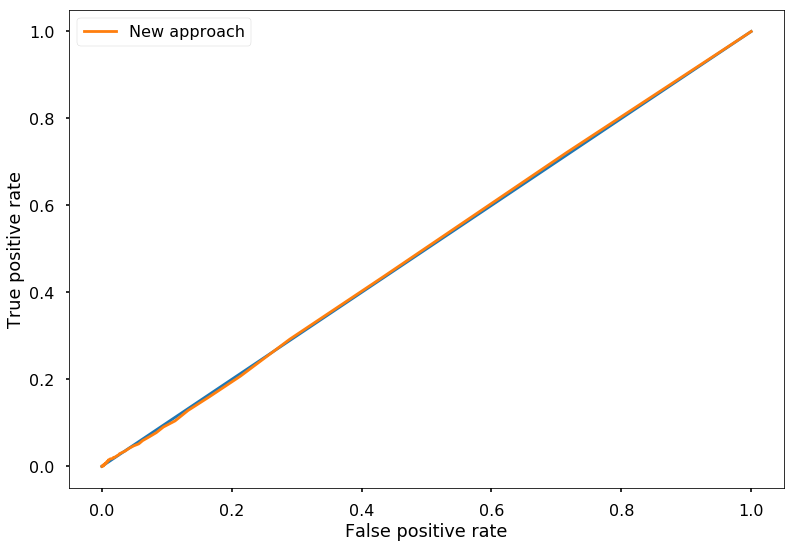

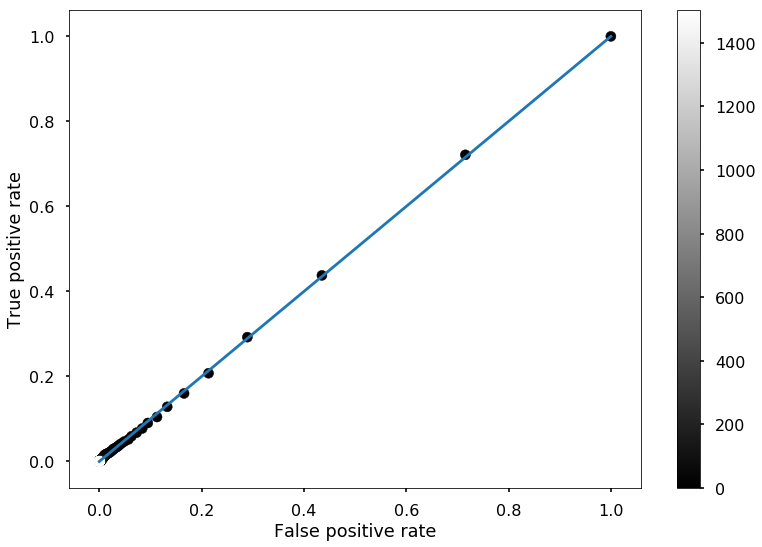

CPU times: user 2min 57s, sys: 958 ms, total: 2min 58s
Wall time: 2min 59s


In [977]:
%%time

ITERATIONS = 5000
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,
                                    points_to_skip = 352
                                   )

# threshold_list = [x/100 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []
actual, predicted, thresholds, generated_ts, change_function = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              points_to_skip = 352,
                                              mode = 'change_end'
                                                       )
#                     for tr in threshold_list:
#                         print(tr)
#                         actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
#                                                                   approach = APPROACH,
#                                                                   max_delay = MAX_DELAY,
#                                                                   _window = WINDOW,
#                                                                   _cp_prob = CP_PROB,
#                                                                   _is_multiplicative = IS_MULTIPLICATIVE,
#                                                                   _threshold = tr,
#                                                                   _is_trend = IS_TREND, 
#                                                                   _change_type = CHANGE_TYPE
#                                                                            )
#                         actual.extend(actual_temp)
#                         predicted.extend(predicted_temp)
#                         thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = MAX_DELAY
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
    if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
        print(cp_result[0])
        print(confusion_matrix(
        [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
        [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
        ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
        print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
df_results = df_results.append(pd.DataFrame(
    {
        'approach': APPROACH, 
        'max_delay': MAX_DELAY, 
        'change_type': CHANGE_TYPE,
        'is_trend': IS_TREND,
        'window': WINDOW, 
        'cp_prob': CP_PROB, 
        'is_multiplicative': IS_MULTIPLICATIVE, 
        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
    }, index=[0]), ignore_index=True
)
print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [156]:
def cp_detection_modeling(approach = 'approximation_mean', 
                            iterations = 1000, 
                            max_delay = 49, 
                            _window = 48, 
                            _cp_prob = 0.8, 
                            _is_multiplicative = True, 
                            threshold_list = [0.15], 
                            _is_trend = False, 
                            _change_type = 'mean', 
                            points_to_skip = None, 
                            mode=None):
    if not points_to_skip:
        points_to_skip = _window
    act, pred, tr = [], [], [] 
    precision = []
    recall = []
    specificity = []
    average_delay = []
    precision_filter = []
    for i in range(iterations):
        generated = data_generator(points_to_skip = points_to_skip, cp_prob = _cp_prob, is_multiplicative = _is_multiplicative, is_trend = _is_trend, change_type = _change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        
        actual_binary = act_binary(generated[0], generated[1], 8)
        for threshold in threshold_list:
            cp_2 = cp_detection(cp_1, threshold)
            predicted_binary = pred_binary(generated[0], cp_2, 8)
            
            cp_result = confusion_matrix(actual_binary,predicted_binary, labels=[0,1])
            tr.append(threshold)
        
            if sum(cp_result[:,1]) == 0:
                precision.append(1)
            else:
                precision.append(cp_result[1,1]/sum(cp_result[:,1]))

            if sum(cp_result[1,:]) == 0:
                recall.append(1)
            else:
                recall.append(cp_result[1,1]/sum(cp_result[1,:]))

            if sum(cp_result[0,:]) == 0:
                specificity.append(1)
            else:
                specificity.append(cp_result[0,0]/sum(cp_result[0,:]))    

#             if cp_result[1]:
#                 average_delay.append(np.mean(cp_result[1]))
#                 precision_filter.append(True)
#             else:
#                 precision_filter.append(False)

#             if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#                 print(cp_result[0])
#                 print(confusion_matrix(
#                 [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#                 [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#                 ))
#                 print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
    unspecificity = [1-x for x in specificity]

    unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
#         print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))
        
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    # plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
    plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()
    # plt.savefig('./fig/approximation_mean_2_roc.png')
    plt.show()

#     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#     plt.scatter(unspecificity, recall, c=tr, s=100, cmap='gray')
#     plt.colorbar()
#     plt.ylabel('True positive rate')
#     plt.xlabel('False positive rate')
#     plt.show()
    
#     return([act, pred, tr])

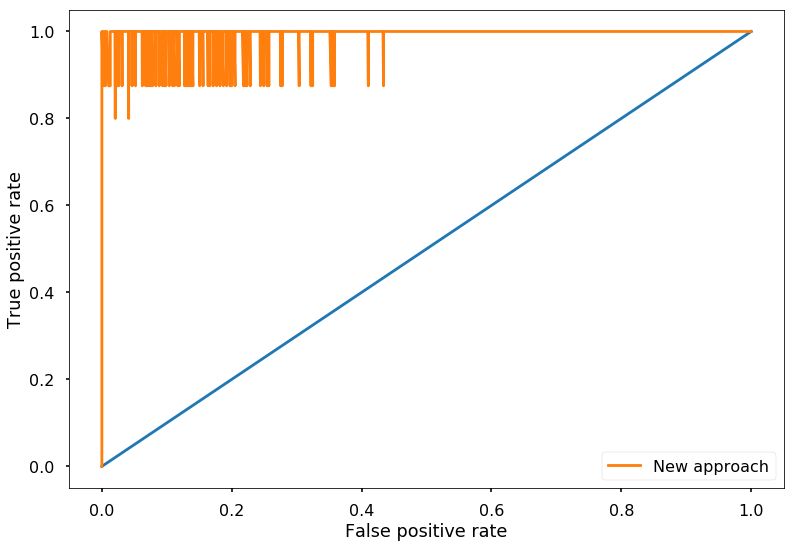

CPU times: user 1min 1s, sys: 196 ms, total: 1min 1s
Wall time: 1min 2s


In [157]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,
                                    points_to_skip = 352
                                   )

cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              points_to_skip = 352,
                                              mode = 'change_end'
                                                       )

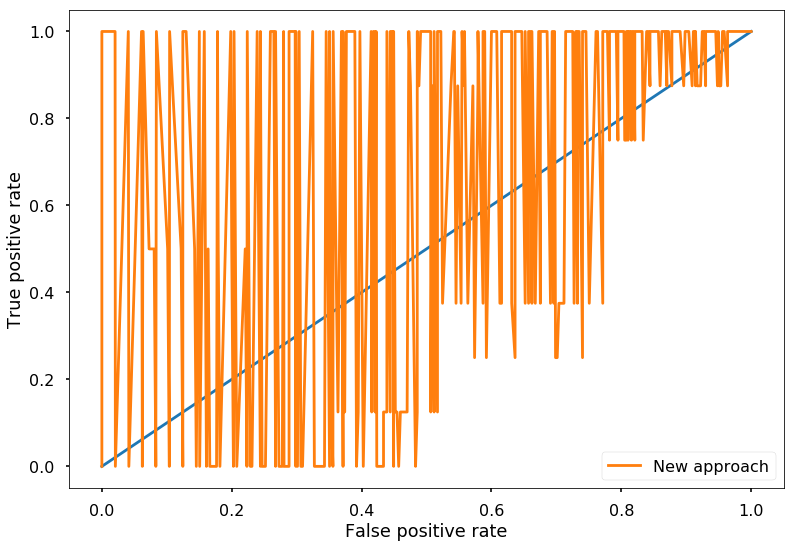

CPU times: user 3.98 s, sys: 33.4 ms, total: 4.01 s
Wall time: 4.06 s


In [161]:
%%time

ITERATIONS = 5
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,
                                    points_to_skip = 352
                                   )

cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              points_to_skip = 352,
                                              mode = 'change_end'
                                                       )

In [ ]:
%%time

ITERATIONS = 5000
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,
                                    points_to_skip = 352
                                   )

# threshold_list = [x/100 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []
actual, predicted, thresholds, generated_ts, change_function = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              points_to_skip = 352,
                                              mode = 'change_end'
                                                       )
#                     for tr in threshold_list:
#                         print(tr)
#                         actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
#                                                                   approach = APPROACH,
#                                                                   max_delay = MAX_DELAY,
#                                                                   _window = WINDOW,
#                                                                   _cp_prob = CP_PROB,
#                                                                   _is_multiplicative = IS_MULTIPLICATIVE,
#                                                                   _threshold = tr,
#                                                                   _is_trend = IS_TREND, 
#                                                                   _change_type = CHANGE_TYPE
#                                                                            )
#                         actual.extend(actual_temp)
#                         predicted.extend(predicted_temp)
#                         thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = MAX_DELAY
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
    if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
        print(cp_result[0])
        print(confusion_matrix(
        [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
        [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
        ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
        print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
df_results = df_results.append(pd.DataFrame(
    {
        'approach': APPROACH, 
        'max_delay': MAX_DELAY, 
        'change_type': CHANGE_TYPE,
        'is_trend': IS_TREND,
        'window': WINDOW, 
        'cp_prob': CP_PROB, 
        'is_multiplicative': IS_MULTIPLICATIVE, 
        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
    }, index=[0]), ignore_index=True
)
print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

[[1025    0]
 [ 412 3563]]
[[1025    0]
 [ 412 3563]]
Recall: 0.90 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 432 3543]]
[[1025    0]
 [ 432 3543]]
Recall: 0.89 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 457 3518]]
[[1025    0]
 [ 457 3518]]
Recall: 0.89 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 483 3492]]
[[1025    0]
 [ 483 3492]]
Recall: 0.88 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 498 3477]]
[[1025    0]
 [ 498 3477]]
Recall: 0.87 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 510 3465]]
[[1025    0]
 [ 510 3465]]
Recall: 0.87 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 528 3447]]
[[1025    0]
 [ 528 3447]]
Recall: 0.87 FPR: 0.00 Threshold: 0.08 Precision: 1.00
[[1025    0]
 [ 557 3418]]
[[1025    0]
 [ 557 3418]]
Recall: 0.86 FPR: 0.00 Threshold: 0.09 Precision: 1.00
[[1025    0]
 [ 573 3402]]
[[1025    0]
 [ 573 3402]]
Recall: 0.86 FPR: 0.00 Threshold: 0.09 Precision: 1.00
[[1025    0]
 [ 598

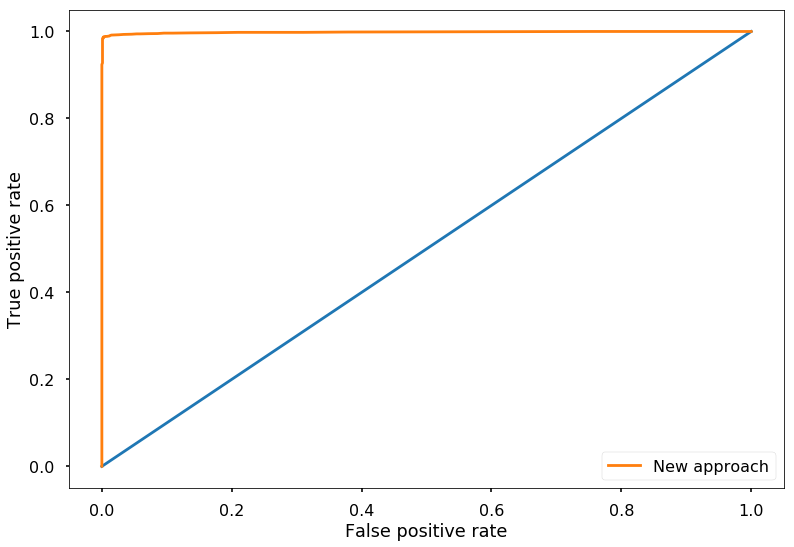

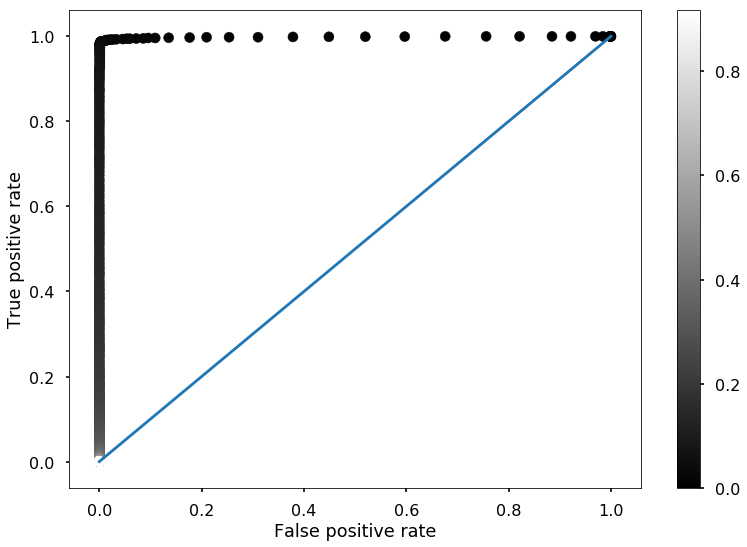

CPU times: user 2min 57s, sys: 885 ms, total: 2min 58s
Wall time: 2min 59s


In [979]:
%%time

ITERATIONS = 5000
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
MAX_DELAY = 48
APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,
                                    points_to_skip = 352
                                   )

# threshold_list = [x/100 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []
actual, predicted, thresholds, generated_ts, change_function = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              max_delay = MAX_DELAY,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              points_to_skip = 352,
                                              mode = 'change_end'
                                                       )
#                     for tr in threshold_list:
#                         print(tr)
#                         actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
#                                                                   approach = APPROACH,
#                                                                   max_delay = MAX_DELAY,
#                                                                   _window = WINDOW,
#                                                                   _cp_prob = CP_PROB,
#                                                                   _is_multiplicative = IS_MULTIPLICATIVE,
#                                                                   _threshold = tr,
#                                                                   _is_trend = IS_TREND, 
#                                                                   _change_type = CHANGE_TYPE
#                                                                            )
#                         actual.extend(actual_temp)
#                         predicted.extend(predicted_temp)
#                         thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = MAX_DELAY
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
    if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
        print(cp_result[0])
        print(confusion_matrix(
        [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
        [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
        ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
        print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
df_results = df_results.append(pd.DataFrame(
    {
        'approach': APPROACH, 
        'max_delay': MAX_DELAY, 
        'change_type': CHANGE_TYPE,
        'is_trend': IS_TREND,
        'window': WINDOW, 
        'cp_prob': CP_PROB, 
        'is_multiplicative': IS_MULTIPLICATIVE, 
        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
    }, index=[0]), ignore_index=True
)
print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [960]:
[(np.isnan(x))*1 for x in df_cp.loc[df_cp['threshold'] == threshold_list[100], 'actual'].values]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [962]:
print(confusion_matrix(
[(np.isnan(x))*1 for x in df_cp.loc[df_cp['threshold'] == threshold_list[100], 'actual']],
[(np.isnan(x))*1 for x in df_cp.loc[df_cp['threshold'] == threshold_list[100], 'predicted']]
))

[[  5 788]
 [  2 205]]


In [950]:
[(x is None)*1 for x in df_cp.loc[df_cp['threshold'] == threshold_list[10], 'predicted']]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [408]:
np.mean([3.80,5.02,4.25,4.54,4.54,4.39])

4.423333333333333

In [ ]:
np.mean([0.98,0.89,0.89
         

In [197]:
np.mean([2.82,
2.20,
2.17,
2.38,
2.15])

2.3440000000000003

In [190]:
'Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr)

'Recall: 0.93 FPR: 0.88 Threshold: 3.78'

In [186]:
tr

3.7800003106239686

In [185]:
1-specificity[-1]

0.875

In [184]:
recall[-1]

0.9285714285714286

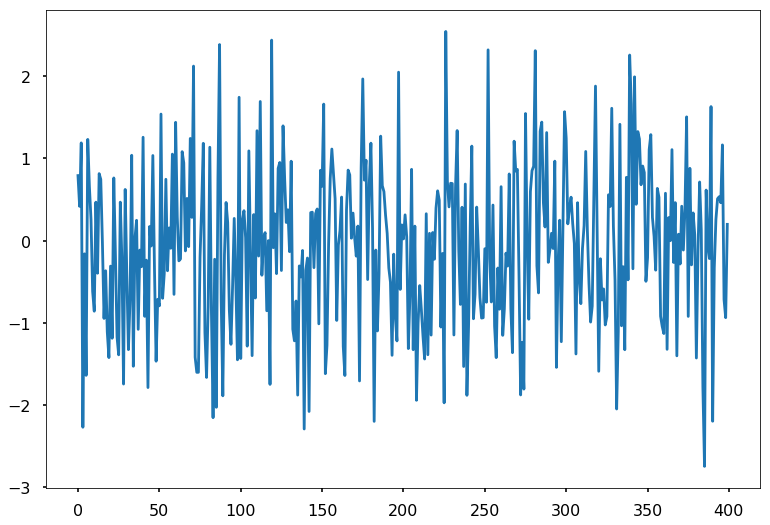

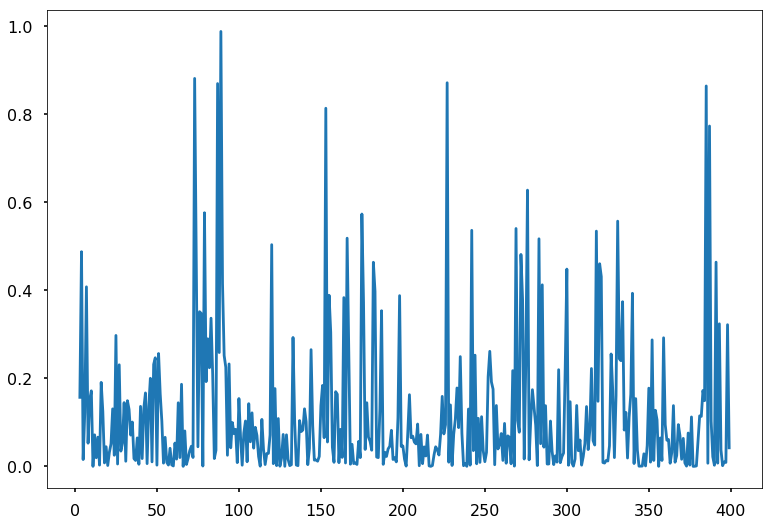

In [167]:
plt.plot(generated_ts[1])
plt.show()
plt.plot(change_function[1])
plt.show()

In [160]:
print(actual[1000])

None


In [165]:
cp_detection(change_function[1], threshold_list[5])


[3,
 4,
 6,
 7,
 9,
 10,
 12,
 14,
 16,
 17,
 23,
 25,
 27,
 30,
 32,
 33,
 34,
 35,
 38,
 40,
 42,
 43,
 45,
 46,
 48,
 49,
 51,
 52,
 53,
 55,
 63,
 65,
 67,
 73,
 74,
 76,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 96,
 97,
 98,
 100,
 101,
 103,
 104,
 106,
 108,
 110,
 111,
 114,
 119,
 120,
 122,
 124,
 127,
 129,
 133,
 134,
 137,
 138,
 139,
 140,
 141,
 144,
 145,
 150,
 151,
 152,
 153,
 155,
 156,
 159,
 160,
 162,
 164,
 166,
 167,
 175,
 176,
 178,
 179,
 182,
 183,
 186,
 187,
 193,
 197,
 198,
 203,
 204,
 205,
 206,
 209,
 211,
 215,
 223,
 224,
 225,
 226,
 227,
 229,
 231,
 232,
 233,
 234,
 235,
 236,
 240,
 242,
 244,
 246,
 248,
 252,
 253,
 254,
 255,
 257,
 260,
 262,
 264,
 265,
 267,
 269,
 270,
 271,
 272,
 273,
 275,
 276,
 278,
 279,
 280,
 281,
 283,
 285,
 287,
 290,
 295,
 299,
 300,
 302,
 306,
 312,
 314,
 315,
 318,
 319,
 320,
 321,
 327,
 328,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 338,
 339,
 340,
 342,
 350,
 352,
 3

In [128]:
actual[0:10]

[360, 360, 360, 360, 360, 360, 360, 360, 360, 360]

In [131]:
threshold_list[0]

0.0

In [127]:
len(actual)

100000

In [130]:
len(threshold_list)

1000

In [23]:
100*100

10000

In [26]:
actual_act = [act for counter, act in enumerate(actual) if counter%1000 == 0]
predicted_pred = [pre for counter, pre in enumerate(predicted) if counter%1000 == 0]

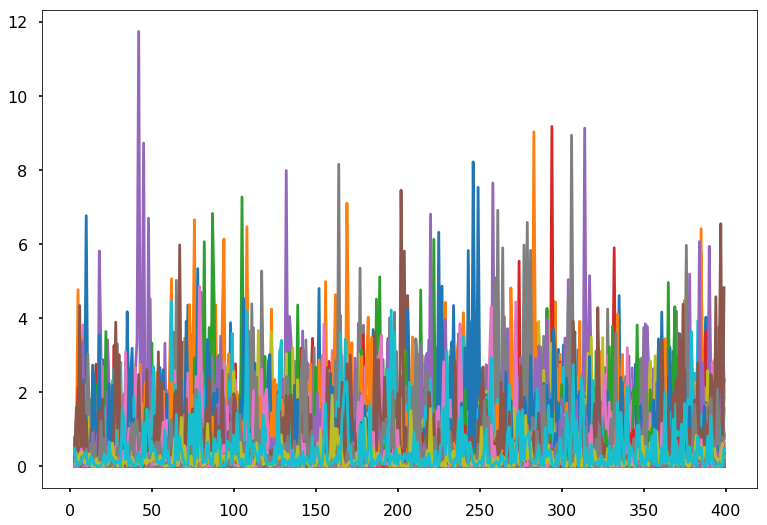

In [33]:
for i in change_function:
    plt.plot(i)
plt.show()

None 352


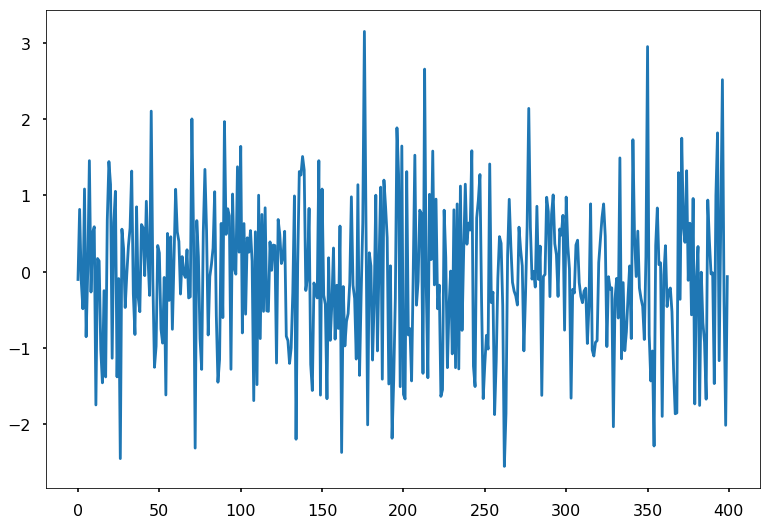

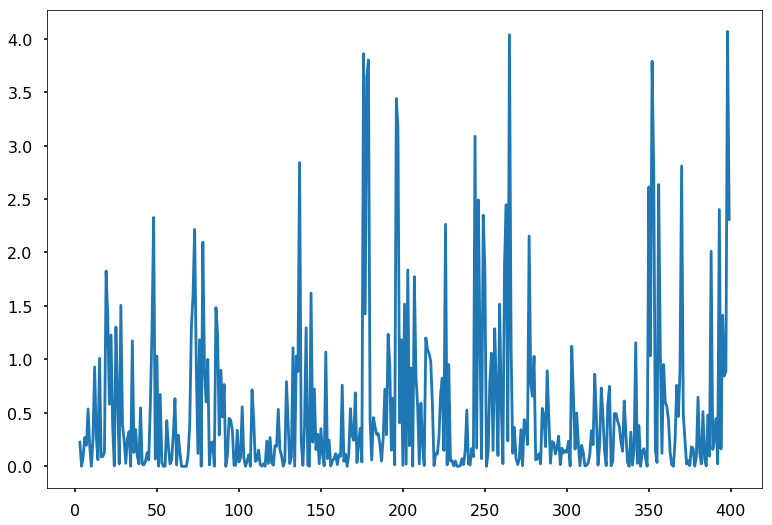

In [32]:
iii = 4

print(actual_act[iii], predicted_pred[iii])
plt.plot(generated_ts[iii])
plt.show()
plt.plot(change_function[iii])
plt.show()

In [12]:
len(change_function)

100

In [451]:
actual[1000]

361

In [438]:
len(actual)

1000000

In [439]:
len(predicted)

1000000

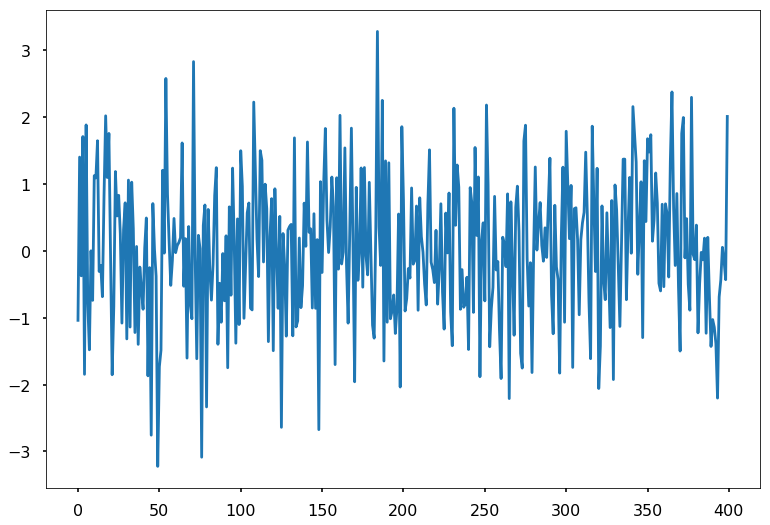

In [433]:
test_generated = data_generator(points_to_skip = 352, 
                           cp_prob = 0.8, 
                           is_multiplicative = False, 
                           is_trend = False, 
                           change_type = 'mean')

plt.plot(test_generated[0])
plt.show()

In [ ]:
cp_2 = cp_detection(cp_1, threshold)

        act.append(generated[1])
        tr.append(threshold)
        if generated[1] == None:
            if len(cp_2) == 0:
                pred.append(None)
            else:
                if mode == 'change_end':
                    pred_list = [cp for cp in cp_2 
                                 if cp >= points_to_skip]
                    if len(pred_list) == 0:
                        pred.append(None)
                    else:
                        pred.append(pred_list[0])
                else:
                    pred.append(cp_2[0])
        else:
            if len(cp_2) == 0:
                pred.append(None)
            else:
                pred_list = [cp for cp in cp_2
                                if ((cp - generated[1]) <= max_delay) &
                                   ((cp - generated[1]) >= 0)]
                if len(pred_list) == 0:
                    pred.append(None)
                else:
                    pred.append(pred_list[0])


In [272]:
unspecificity_sorted

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [271]:
recall_sorted

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479192938,
 0.0012610340479

In [273]:
threshold_list

[0.0,
 0.0055353403681603994,
 0.011070680736320799,
 0.0166060211044812,
 0.022141361472641598,
 0.027676701840801995,
 0.0332120422089624,
 0.0387473825771228,
 0.044282722945283196,
 0.04981806331344359,
 0.05535340368160399,
 0.060888744049764396,
 0.0664240844179248,
 0.07195942478608519,
 0.0774947651542456,
 0.08303010552240599,
 0.08856544589056639,
 0.0941007862587268,
 0.09963612662688719,
 0.10517146699504759,
 0.11070680736320798,
 0.11624214773136839,
 0.12177748809952879,
 0.12731282846768918,
 0.1328481688358496,
 0.13838350920401,
 0.14391884957217038,
 0.14945418994033077,
 0.1549895303084912,
 0.16052487067665158,
 0.16606021104481197,
 0.1715955514129724,
 0.17713089178113278,
 0.18266623214929317,
 0.1882015725174536,
 0.19373691288561398,
 0.19927225325377437,
 0.2048075936219348,
 0.21034293399009518,
 0.21587827435825557,
 0.22141361472641596,
 0.22694895509457638,
 0.23248429546273677,
 0.23801963583089716,
 0.24355497619905758,
 0.24909031656721797,
 0.25462565

In [232]:
cp_quality([test_act], [test_pred], 48)

(array([[0, 0],
        [1, 0]]), [])

In [373]:
cp_detection(test_cp_1, 0)

[]

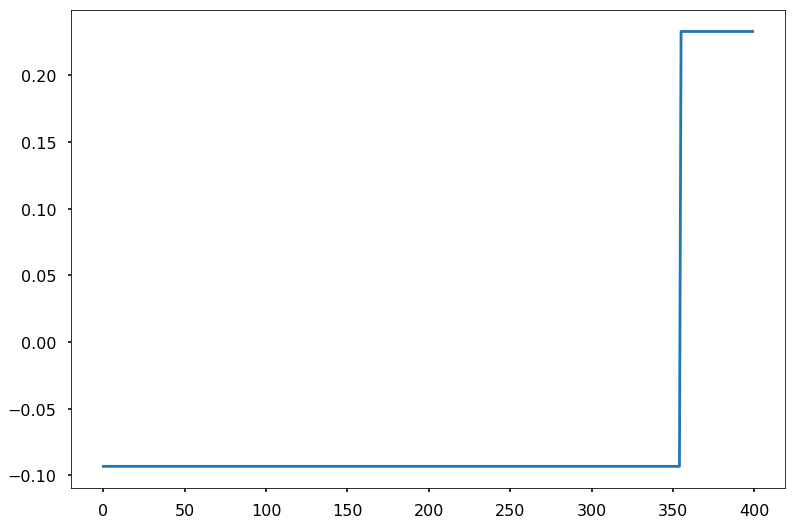

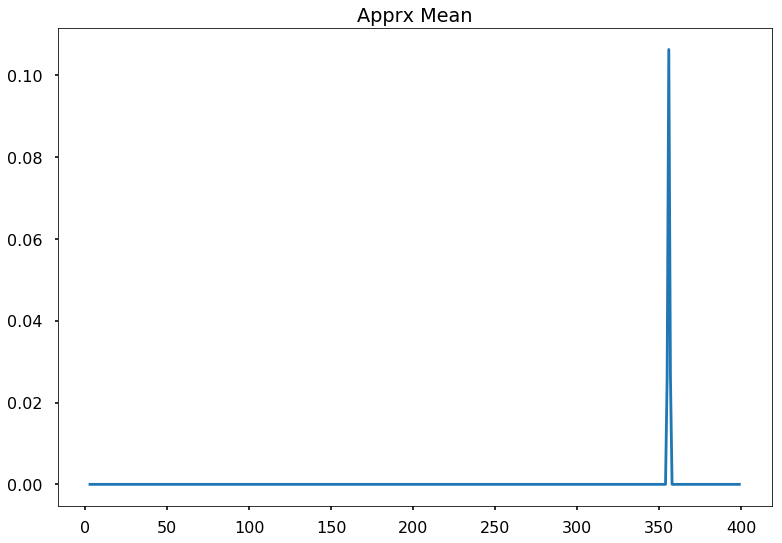

Actual: 355/ Predicted: None
(array([[0, 0],
       [1, 0]]), [])


In [378]:
# while cp_quality([test_act], [test_pred], 48)[0][1,1] != 0:
test_generated = data_generator(points_to_skip = 352, 
                           cp_prob = 0.8, 
                           is_multiplicative = False, 
                           is_trend = False, 
                           change_type = 'mean')
test_cp_1 = approximation_mean(test_generated[0], window=4)
# test_cp_2 = approximation_trend(test_generated[0], window=48)
# test_cp_3 = approximation_sin_trend(test_generated[0], window=48)
# test_cp_4 = approximation_sin_insight_trend(test_generated[0], window=48)
# test_cp_5 = prediction_mean(test_generated[0], window=48)
# test_cp_6 = prediction_trend(test_generated[0], window=48)
# test_cp_7 = prediction_sin_trend(test_generated[0], window=48)
# test_cp_8 = prediction_sin_insight_trend(test_generated[0], window=48)


# prediction_sin_insight_trend

# print(test_generated[1])
plt.plot(test_generated[0])
plt.show()
plt.plot(test_cp_1)
plt.title('Apprx Mean')
plt.show()

test_cp_2 = cp_detection(test_cp_1, 2.69571)

test_act = test_generated[1]


if test_generated[1] == None:
    if len(test_cp_2) == 0:
        test_pred = None
    else:
        test_pred_list = [cp for cp in test_cp_2 if cp >= 352]
        if len(test_pred_list) == 0:
            test_pred = None
        else:
            test_pred = test_pred_list[0]
else:
    if len(test_cp_2) == 0:
        test_pred = None
    else:
        test_pred_list = [cp for cp in test_cp_2
                        if ((cp - test_generated[1]) <= 50) &
                           ((cp - test_generated[1]) >= 0)]
        if len(test_pred_list) == 0:
            test_pred = None
        else:
            test_pred = test_pred_list[0]

print('Actual: {}/ Predicted: {}'.format(test_act, test_pred))

print(cp_quality([test_act], [test_pred], 50))

In [234]:
cp_detection(test_cp_1, 0.000239)

[47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 72,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 95,
 96,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 136,
 159,
 163,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 189,
 192,
 201,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 243,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,


In [238]:
test_act

397

In [237]:
test_pred

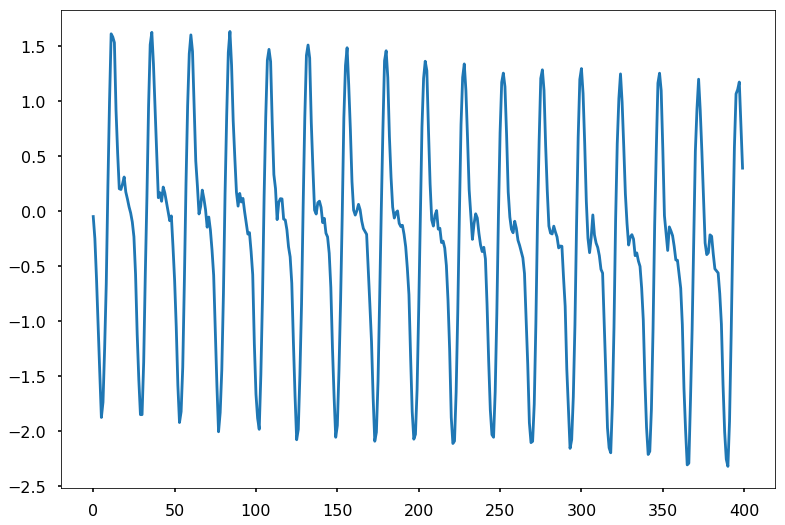

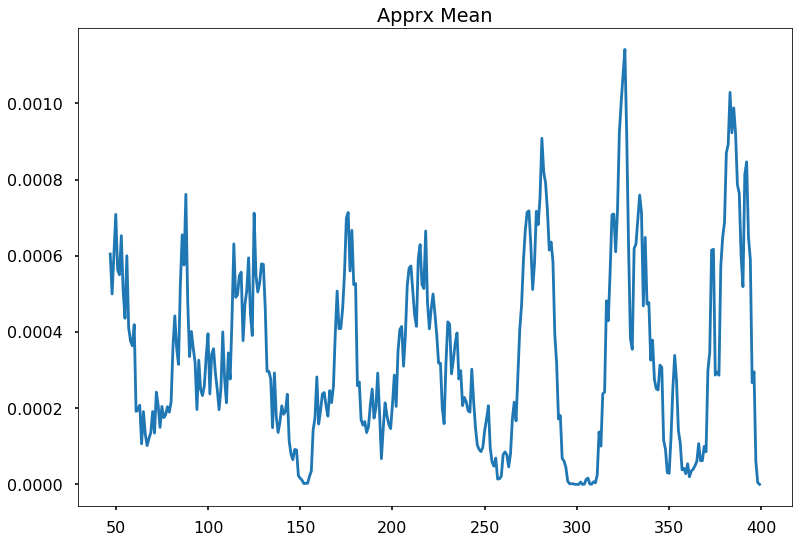

Actual: 397/ Predicted: None
(array([[0, 0],
       [1, 0]]), [])


In [233]:
plt.plot(test_generated[0])
plt.show()
plt.plot(test_cp_1)
plt.title('Apprx Mean')
plt.show()

print('Actual: {}/ Predicted: {}'.format(test_act, test_pred))

print(cp_quality([test_act], [test_pred], 48))

1

In [105]:
cp_detection(test_cp_1, 0.0001)

[65,
 66,
 67,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 120,
 121,
 135,
 159,
 191,
 192,
 193,
 215,
 269,
 271,
 272,
 273,
 274,
 275,
 276,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 303,
 326,
 327,
 330,
 333,
 334,
 335,
 337,
 338,
 341,
 350,
 351,
 352,
 353,
 354,
 357,
 358,
 374,
 375,
 376,
 377,
 378]

In [99]:
[cp if cp >= 352 else None for cp in test_cp_2]

387

387

(array([[0, 0],
        [0, 1]]), [0])